In [51]:
import numpy as np

from scipy.spatial.transform import Rotation as R

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from astropy import units as u
from astropy import constants as cst

# from aqn import *
# from constants import *

from itertools import product
import scipy.stats as stats
import pickle

In [4]:
# FIRE's m12i data cube can be downloaded by running:
# wget -r -np https://users.flatironinstitute.org/~chayward/fire2_public_release/core_FIRE-2_runs/m12i_res7100/

In [2]:
# open the saved file if there is one:
with open('../data/FIRE/part.pkl', 'rb') as file: part = pickle.load(file)
print(">> imported FIRE simulation data")

>> imported FIRE simulation data


In [95]:
# define cube resolution parameters
cube_length       = 20   # kpc # 20 for radio
voxel_resolution  = 2**9 # bins / kpc
print(f">> voxels per length: {voxel_resolution}")

voxel_length = cube_length / voxel_resolution * u.kpc
voxel_volume = voxel_length**3

# create bins based on defined resolution parameters
bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin center coordinates will be used to identify voxels
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers, bin_centers]) # kpc

# create empty dictionaries for dark matter and gas components
dark_mat, all_gas = {}, {}
dark_mat["name"], all_gas["name"] = "Dark Matter", "Gas"
dark_mat["short-name"], all_gas["short-name"] = "dark_mat", "gas"

>> voxels per length: 512


In [26]:
########### Obtain Proper Rotation ########
def obtain_rotation(part):
    gas = {}
    gas["masses"] = part["gas"].prop("mass")
    gas["coords"] = part['gas'].prop('host.distance')
    
    gas["x"], gas["y"], gas["z"] = gas["coords"][:,0], gas["coords"][:,1], gas["coords"][:,2]
    gas["r"] = np.sqrt(gas["x"]**2 + gas["y"]**2 + gas["z"]**2)
    
    # gas["region"] = np.where(gas["r"] < 5)  
    gas["region"] = np.where((gas["r"] < 9.2) & (gas["r"] > 7.6))  
    
    for i in ["masses", "x", "y", "z", "r", "coords"]:
        gas[i] = gas[i][gas["region"]]
    
    # Assume gas is your dictionary with coordinates and masses
    x = gas["x"]
    y = gas["y"]
    z = gas["z"]
    masses = gas["masses"]
    
    # Compute the square root of the masses for weighting
    weights = np.sqrt(masses)
    
    # Construct the weighted matrix A
    A = np.vstack([x * weights, y * weights, weights]).T
    
    # Apply weights to z as well
    z_weighted = z * weights
    
    # Solve for the coefficients a, b, c with weighted least squares
    coefficients, residuals, _, _ = np.linalg.lstsq(A, z_weighted, rcond=None)
    
    a, b, c = coefficients
    
    # The normal vector to the plane
    normal_vector = np.array([a, b, -1])
    normal_vector /= np.linalg.norm(normal_vector)
    
    # Calculate the axis of rotation (cross product with z-axis)
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(normal_vector, z_axis)
    rotation_axis /= np.linalg.norm(rotation_axis)
    
    # Calculate the angle of rotation
    theta = np.arccos(np.dot(normal_vector, z_axis))
    
    # Construct the rotation matrix
    rotation = R.from_rotvec(rotation_axis * theta)
    rotation_matrix = rotation.as_matrix()
    
    # Apply the rotation to the galaxy coordinates
    rotated_coordinates = rotation.apply(np.vstack([x, y, z]).T)
    
    # Update the gas dictionary with the new rotated coordinates
    gas["x"], gas["y"], gas["z"] = rotated_coordinates.T
    gas["coords"] = rotation.apply(gas["coords"])
    
    return rotation

In [109]:
dictt

{'name': 'Gas',
 'short-name': 'gas',
 'masses': array([7128.0854, 7067.277 , 7067.277 , ..., 7067.277 , 7076.5327,
        7838.638 ], dtype=float32),
 'temp': array([22878.559 ,  1367.0372,   669.6197, ...,  5890.901 ,  6221.548 ,
         6303.6455], dtype=float32),
 'efrac': array([1.1672828, 1.1666703, 1.1666812, ..., 1.1666255, 1.166889 ,
        1.1722765], dtype=float32),
 'coords': array([[-3324.93546772, -2009.40471972, -4565.86701969],
        [-2585.535795  , -2411.55844559, -5375.90080379],
        [-2067.96341   , -2533.02541797, -4144.30236647],
        ...,
        [ 1344.2585636 , -1714.2016047 ,   715.03836012],
        [ 1335.88995106, -1720.79172928,   715.3466264 ],
        [ 1339.57414493, -1718.91490516,   697.692014  ]])}

In [110]:
dark_mat["masses"] = part["dark"].prop("mass")
all_gas["masses"] = part["gas"].prop("mass")

# obtain coordinates of all particles within cube relative to Milky Way center
dark_mat["coords"] = part['dark'].prop('host.distance')
all_gas["coords"] = part['gas'].prop('host.distance')

all_gas["temp"] = part['gas'].prop('temperature')
all_gas["efrac"] = part["gas"].prop("electron.fraction")

# apply rotation
rotation = obtain_rotation(part)
for dictt in [dark_mat, all_gas]:
    dictt["coords"] = rotation.apply(dictt["coords"])

dark_mat["within_cube"] = np.where((np.abs(dark_mat["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(dark_mat["coords"][:,1]) < cube_length/2) &
                                   (np.abs(dark_mat["coords"][:,2]) < cube_length/2))
all_gas["within_cube"] = np.where((np.abs(all_gas["coords"][:,0])  < cube_length/2) & 
                                   (np.abs(all_gas["coords"][:,1])  < cube_length/2) &
                                   (np.abs(all_gas["coords"][:,2])  < cube_length/2))

for dictt in [dark_mat, all_gas]:
    for key in dictt.keys():
        if key != "name" and key != "short-name" and key != "within_cube" and key != "coords":
            print(dictt["name"], "---", key)
            dictt[key] = dictt[key][dictt["within_cube"]]
            print(dictt[key].shape)

Dark Matter --- masses
(1925489,)
Gas --- masses
(1178295,)
Gas --- temp
(1178295,)
Gas --- efrac
(1178295,)


In [121]:
# fraction of gas particles with efrac > 0.9:
print(len(all_gas["efrac"][all_gas["efrac"]>0.9]) / len(all_gas["efrac"]) * 100)

3.5594651594040543


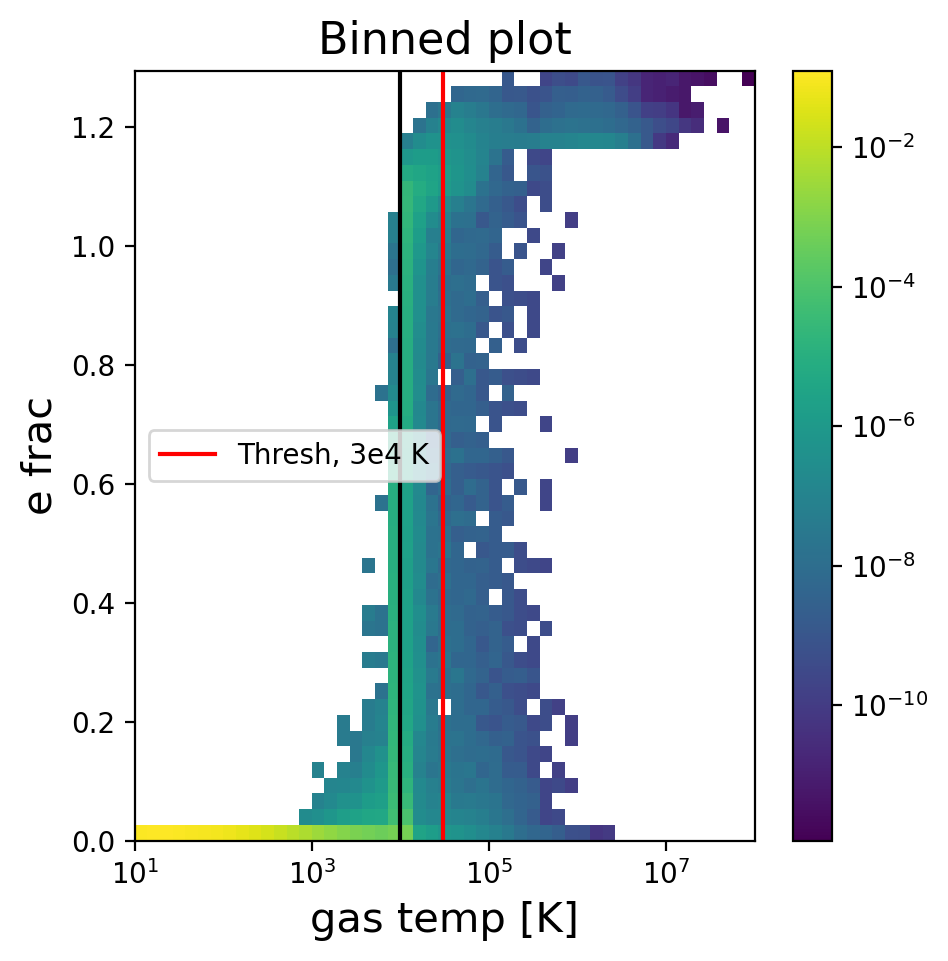

In [217]:
from matplotlib.colors import LogNorm
plt.figure(dpi=200, figsize=(5,5))

plt.ylabel("e frac",size=15)
plt.xlabel("gas temp [K]",size=15)
# bins = np.linspace(-10,10, 100)
plt.hist2d(all_gas["temp"],
           all_gas["efrac"], bins=[np.logspace(1,8,50), np.linspace(0,np.max(all_gas["efrac"]),50)], norm=LogNorm(), density=True)
plt.title("Binned plot", size=16)
plt.xscale("log")
plt.colorbar()
plt.axvline(3e4, color="red", label="Thresh, 3e4 K")
plt.axvline(1e4, color="black")

plt.legend(loc='center left')
plt.savefig("../visuals/efrac_vs_gas_temp.png", bbox_inches="tight")
plt.show()

In [210]:
 cubes["gas_efrac"].reshape(voxel_resolution**3)

<Quantity [1120589.8799627 , 1120589.8799627 , 1120589.8799627 , ...,
           2462020.84280743, 2462020.84280743, 2462020.84280743] K>

In [269]:
np.max(all_gas["efrac"])

1.2942605

In [270]:
np.max(cubes["gas_efrac"])

1.2942605400069829

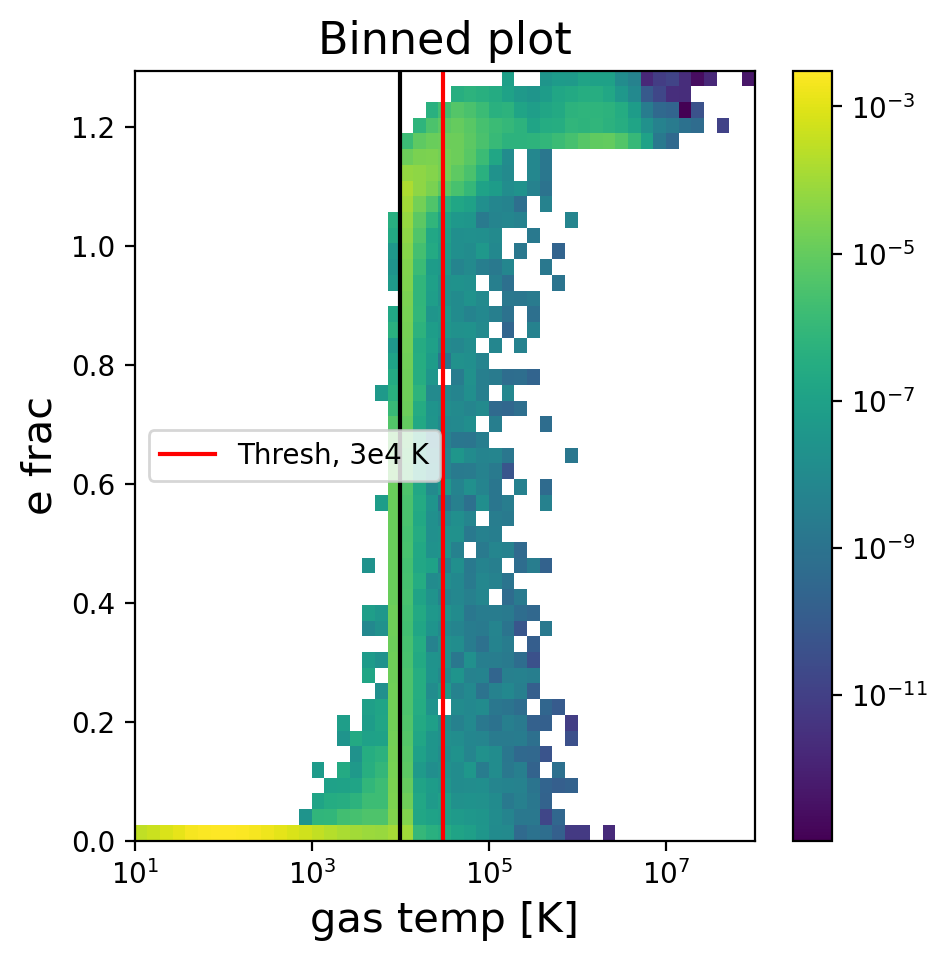

In [212]:
from matplotlib.colors import LogNorm
plt.figure(dpi=200, figsize=(5,5))

plt.ylabel("e frac",size=15)
plt.xlabel("gas temp [K]",size=15)
# bins = np.linspace(-10,10, 100)
plt.hist2d(cubes["gas_temp"].reshape(voxel_resolution**3).value,
           cubes["gas_efrac"].reshape(voxel_resolution**3), bins=[np.logspace(1,8,50), np.linspace(0,np.max(all_gas["efrac"]),50)], norm=LogNorm(), density=True)
plt.title("Binned plot", size=16)
plt.xscale("log")
plt.colorbar()
plt.axvline(3e4, color="red", label="Thresh, 3e4 K")
plt.axvline(1e4, color="black")

plt.legend(loc='center left')
plt.savefig("../visuals/efrac_vs_gas_temp.png", bbox_inches="tight")
plt.show()

(array([391011.,  12056.,   7581.,   5796.,   5151.,   5139.,   5868.,
          9072.,  16698.,  15847.]),
 array([8.50011304e-40, 1.29426054e-01, 2.58852108e-01, 3.88278162e-01,
        5.17704216e-01, 6.47130270e-01, 7.76556324e-01, 9.05982378e-01,
        1.03540843e+00, 1.16483449e+00, 1.29426054e+00]),
 <BarContainer object of 10 artists>)

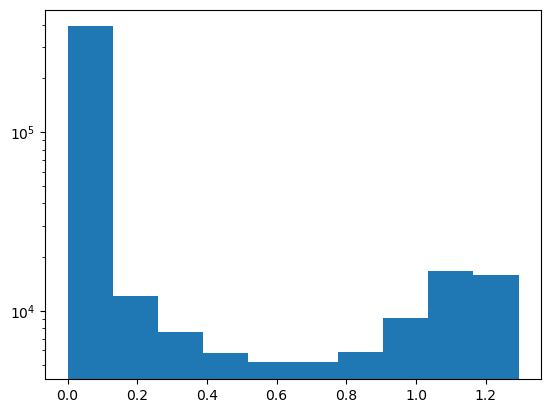

In [228]:
plt.hist(all_gas["binned_efrac"][non_empty_efrac_ids], log=True)

In [163]:
len(all_gas["efrac"][all_gas["efrac"] < 1e-40]) / len(all_gas["efrac"])

0.5765983900466352

(array([1094983.,   12100.,    7597.,    5797.,    5158.,    5148.,
           5875.,    9077.,   16710.,   15850.]),
 array([0.        , 0.12942605, 0.25885209, 0.38827816, 0.51770419,
        0.64713025, 0.77655631, 0.90598238, 1.03540838, 1.1648345 ,
        1.2942605 ]),
 <BarContainer object of 10 artists>)

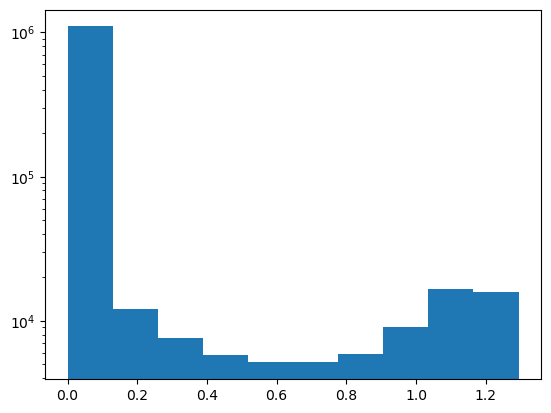

In [229]:
plt.hist(all_gas["efrac"], log=True)

(array([11719800.,  1214454.,   929752.,   833940.,   851404.,   969244.,
         1347290.,  2734690., 15212080., 98405074.]),
 array([0.        , 0.12942605, 0.25885211, 0.38827816, 0.51770422,
        0.64713027, 0.77655632, 0.90598238, 1.03540843, 1.16483449,
        1.29426054]),
 <BarContainer object of 10 artists>)

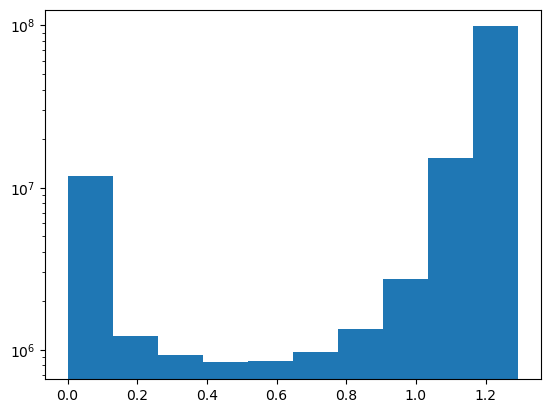

In [231]:
plt.hist(cubes["gas_efrac"].reshape(voxel_resolution**3), log=True)

In [246]:
np.min(all_gas["binned_temp"])

<Quantity 0. K>

28846.166


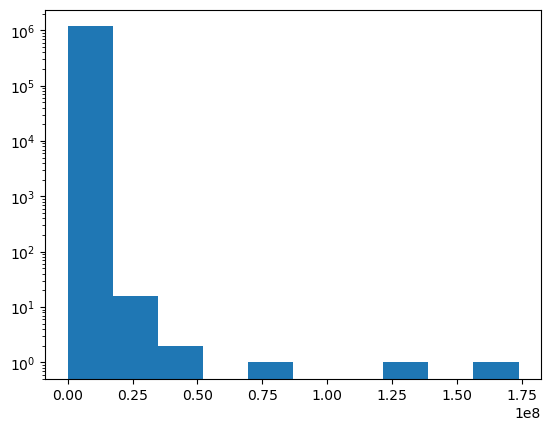

38648.335986919294 K


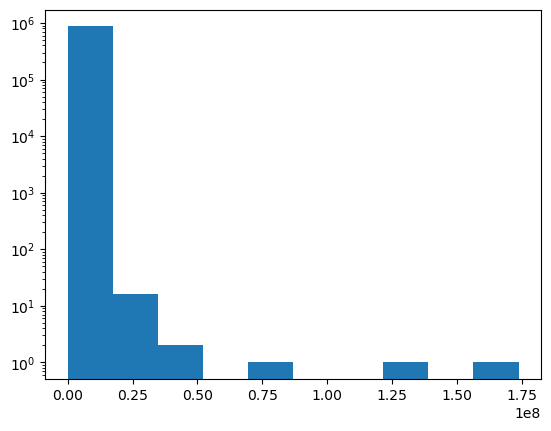

1588823.5131713003 K


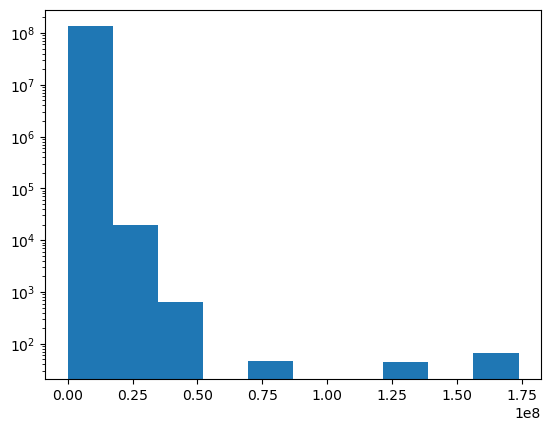

In [249]:
plt.hist(all_gas["temp"], log=True)
print(np.mean(all_gas["temp"]))
plt.show()
plt.hist(all_gas["binned_temp"].reshape(voxel_resolution**3)[all_gas["binned_temp"].reshape(voxel_resolution**3)!=0], log=True)
print(np.mean(all_gas["binned_temp"][all_gas["binned_temp"]!=0]))
plt.show()
plt.hist(cubes["gas_temp"].reshape(voxel_resolution**3), log=True)
print(np.mean(cubes["gas_temp"]))

In [268]:
# all_gas.keys()
# all_gas["binned_efrac"]
np.max(cubes_gas_efrac)

1.2942605400069829

(array([1.34217527e+08, 1.46000000e+02, 2.10000000e+01, 1.90000000e+01,
        1.00000000e+00, 5.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        3.00000000e+00, 2.00000000e+00]),
 array([0.00000000e+00, 8.53702718e-26, 1.70740544e-25, 2.56110815e-25,
        3.41481087e-25, 4.26851359e-25, 5.12221631e-25, 5.97591903e-25,
        6.82962175e-25, 7.68332446e-25, 8.53702718e-25]),
 <BarContainer object of 10 artists>)

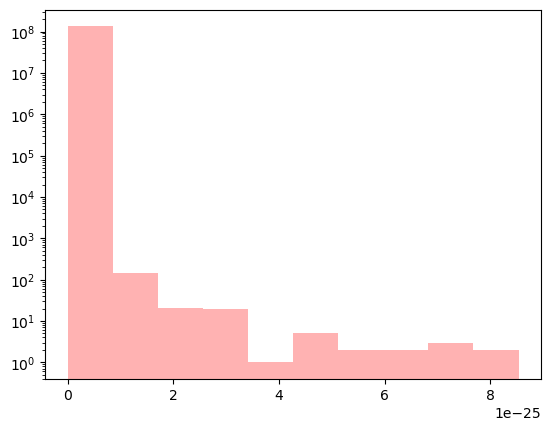

In [266]:
# plt.hist(all_gas["efrac"]*all_gas["masses"], log=True, alpha=0.3)
binned_efrac = all_gas["binned_efrac"].reshape(voxel_resolution**3)
mass_count = all_gas["mass_count"].reshape(voxel_resolution**3)
# plt.hist(binned_efrac[mass_count!=0]*mass_count[mass_count!=0], log=True, alpha=0.3)
cubes_gas_efrac = cubes["gas_efrac"].reshape(voxel_resolution**3)
cubes_gas_density = cubes["gas_density"].reshape(voxel_resolution**3)
plt.hist(cubes_gas_efrac*cubes_gas_density*voxel_volume, log=True, alpha = 0.3, color="red")

In [273]:
np.average(cubes_gas_efrac, weights=cubes_gas_density)

<Quantity 0.05281333>

In [276]:
np.average(binned_efrac[mass_count!=0], weights=mass_count[mass_count!=0])

0.05281332773759622

In [278]:
# all_gas["efrac"]*all_gas["masses"]
np.average(all_gas["efrac"], weights=all_gas["masses"])

0.052813303

In [41]:
# part is no longer needed, saves ~11 GB
del part

In [129]:
# use histograms to obtain mass counts and velocities within each voxel
print(f">> binning masses", end="")
for dictt in [dark_mat, all_gas]:

    
    # bin all particle masses within cube, weighing by their mass
    dictt["mass_count"], bin_edges, bin_numbers = stats.binned_statistic_dd(dictt["coords"][dictt["within_cube"]],
                          dictt["masses"],
                          statistic='sum',
                          bins=(bins,bins,bins),
                          expand_binnumbers=True)
    print(".", end="")


>> binning masses..



In [175]:
all_gas["binned_temp"][non_empty_temp].shape

(872376,)

In [177]:
all_gas["mass_count"][all_gas["mass_count"] != 0].shape

(872376,)

In [187]:
all_gas["binned_efrac"][non_empty_efrac].shape

(872376,)

In [185]:
np.sum(grid_ids_gas - grid_ids_gas_temp)

0

In [180]:

# grid_ids_gas 
# grid_ids_gas_temp
# grid_ids_gas_efrac

In [186]:
# bin all ionized gas particle temperatures within cube, weighing by their mass
print(f">> binning all_gas temperatures, weighed by mass")
temperatures, bin_edges, bin_numbers = stats.binned_statistic_dd(all_gas["coords"][all_gas["within_cube"]], 
                      all_gas["temp"]*all_gas["masses"], 
                      statistic='sum', 
                      bins=(bins,bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

print(f">> binning all_gas efrac, weighed by mass")
efrac, bin_edges, bin_numbers = stats.binned_statistic_dd(all_gas["coords"][all_gas["within_cube"]], 
                      all_gas["efrac"]*all_gas["masses"], 
                      statistic='sum', 
                      bins=(bins,bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

all_gas["binned_temp"] = temperatures * u.K
non_empty_temp = temperatures != 0
all_gas["binned_temp"][non_empty_temp] = temperatures[non_empty_temp] / all_gas["mass_count"][non_empty_temp] * u.K

all_gas["binned_efrac"] = efrac
non_empty_efrac = all_gas["mass_count"] != 0 # efrac != 0
all_gas["binned_efrac"][non_empty_efrac] = efrac[non_empty_efrac] / all_gas["mass_count"][non_empty_efrac]

>> binning all_gas temperatures, weighed by mass
>> binning all_gas efrac, weighed by mass


In [46]:
# del temperatures
# del non_empty_v_x, non_empty_v_x, non_empty_v_x
del non_empty_temp
del velocities
del bin_numbers
del bin_edges
# for dict in [dark_mat, neut_gas, ioni_gas]:
#     del dict["v_x"], dict["v_y"], dict["v_z"]
del dict


In [67]:
import gc
gc.collect()

3866

In [139]:
# calculate densities from mass counts
print(f">> calculating density voxels from mass count voxels")
print(f"----", end="\r")
dark_mat["density"] = (dark_mat["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(f"#---", end="\r")
all_gas["density"] = (all_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(f"####")

>> calculating density voxels from mass count voxels
####


In [52]:
# we now have everything that we need:
# dark_mat["density"], neut_gas["density"], ioni_gas["density"], dv_neut, dv_ioni, ioni_gas["temperatures"]

In [144]:
# grid_c

In [145]:
print(f"\n>> saving files for voronoi voxelization's nearest neighbour search")

xx_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[0]#.astype(np.float32)
yy_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[1]#.astype(np.float32)
zz_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[2]#.astype(np.float32)

grid_c = np.vstack((xx_c.ravel(), yy_c.ravel(), zz_c.ravel())).T
# np.save('../data/FIRE/jan9/grid-coords.npy', grid_c)
# print(f"\tgrid coordinates:\n\t../data/FIRE/grid-coords.npy\n")

print(f"\tdensities:")
for dictt in [dark_mat, all_gas]:
    non_empty_ids = dictt["density"]!=0
    non_empty_coords = np.array([xx_c[non_empty_ids], yy_c[non_empty_ids], zz_c[non_empty_ids]]).transpose()

    save_file =  '../data/FIRE/jan9/non-empty-coords-'+dictt["short-name"]+'.npy'
    np.save(save_file, non_empty_coords)
    print(f"\t{save_file}")

print(f"\n\tgas temperature:")
non_empty_temp_ids = all_gas["binned_temp"]!=0
non_empty_temp_coords = np.array([xx_c[non_empty_temp_ids], yy_c[non_empty_temp_ids], zz_c[non_empty_temp_ids]]).transpose()
save_file =  '../data/FIRE/jan9/non-empty-coords-'+'all_gas-temp'+'.npy'
np.save(save_file, non_empty_temp_coords)
print(f"\t{save_file}")

print(f"\n\tgas efrac:")
non_empty_efrac_ids = all_gas["binned_efrac"]!=0
non_empty_efrac_coords = np.array([xx_c[non_empty_efrac_ids], yy_c[non_empty_efrac_ids], zz_c[non_empty_efrac_ids]]).transpose()
save_file =  '../data/FIRE/jan9/non-empty-coords-'+'all_gas-efrac'+'.npy'
np.save(save_file, non_empty_efrac_coords)
print(f"\t{save_file}")


>> saving files for voronoi voxelization's nearest neighbour search
	densities:
	../data/FIRE/jan9/non-empty-coords-dark_mat.npy
	../data/FIRE/jan9/non-empty-coords-gas.npy

	gas temperature:
	../data/FIRE/jan9/non-empty-coords-all_gas-temp.npy

	gas efrac:
	../data/FIRE/jan9/non-empty-coords-all_gas-efrac.npy


array([2.35187419e-01, 9.33601949e-07, 4.41653400e-04, ...,
       1.02279289e+00, 1.08760950e+00, 8.87225092e-01])

In [149]:
non_empty_coords.shape

(872376, 3)

In [282]:
def plot_pre_voronoi(x, unit_label, save_name):
    z_slice_min, z_slice_max = [-0.5,0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.sum(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("Pre-voronoi", size=20)
    
    plt.savefig(save_name+".png", bbox_inches='tight')
    plt.savefig(save_name+".svg", bbox_inches='tight')
    
    plt.show()
    # plt.close()

def plot_post_voronoi(x, unit_label, save_name):
    z_slice_min, z_slice_max = [-0.5, 0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.average(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("Post-voronoi", size=20)
    
    plt.savefig(save_name+".png", bbox_inches='tight')
    plt.savefig(save_name+".svg", bbox_inches='tight')
    
    # plt.close()
    plt.show()

def plot_pre_voronoi_efrac(x, unit_label, save_name):
    z_slice_min, z_slice_max = [-0.5,0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.average(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], vmin = 0, vmax = 1.29)
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("Pre-voronoi", size=20)
    
    plt.savefig(save_name+".png", bbox_inches='tight')
    plt.savefig(save_name+".svg", bbox_inches='tight')
    
    plt.show()
    # plt.close()

def plot_post_voronoi_efrac(x, unit_label, save_name):
    z_slice_min, z_slice_max = [-0.5, 0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.average(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], vmin = 0, vmax = 1.29)
    
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("Post-voronoi", size=20)
    
    plt.savefig(save_name+".png", bbox_inches='tight')
    plt.savefig(save_name+".svg", bbox_inches='tight')
    
    # plt.close()
    plt.show()

def compute_voronoi_cube_density(grid_c, grid_ids, dictt):
    non_empty_points = dictt["density"] != 0
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dictt["density"], voxel_resolution**3)

    # divide by the bincount to average the density across the voronoi volumes
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result

def compute_voronoi_cube_temp(gric_c, grid_ids, dictt):
    non_empty_points = dictt["binned_temp"] != 0
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dictt["binned_temp"], voxel_resolution**3)

    # don't divide by the bincount here, we don't want to average across voronoi volumes for the temperatures
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] # / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result  

def compute_voronoi_cube_efrac(gric_c, grid_ids, dictt):
    non_empty_points = all_gas["density"] != 0 
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dictt["binned_efrac"], voxel_resolution**3)

    # don't divide by the bincount here, we don't want to average across voronoi volumes for the temperatures
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] # / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result    

def compute_voronoi_cube_vel(gric_c, grid_ids, dictt, dir = "v_x"):
    non_empty_points = dictt[dir] != 0
    
    non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
    quantity = np.reshape(dictt[dir], voxel_resolution**3)

    # don't divide by the bincount here, we don't want to average across voronoi volumes for the temperatures
    voronoied_result = quantity[non_empty_points_reshaped][grid_ids] # / np.bincount(grid_ids)[grid_ids]
    voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

    return voronoied_result   

In [194]:
a = all_gas["density"] != 0
a.shape

(512, 512, 512)

In [72]:
# load grid point centres from a file to speed up code
grid_c = np.load("../data/FIRE/grid-coords.npy")

In [73]:
counter = np.array([0])
m = 30

In [74]:
# counter = np.array([0])
def advance():
    print("#"*counter[0] + "-"*(m-counter[0]), end="\r")
    counter[0] = counter[0] + 1

advance()

In [168]:
advance()
grid_ids_dark = np.load('../data/FIRE/jan9/grid-ids--dark_mat-cKDTree.npy').astype(int)
advance()
grid_ids_gas = np.load('../data/FIRE/jan9/grid-ids--gas-cKDTree.npy').astype(int)
advance()
# grid_ids_gas_temp = np.load('../data/FIRE/jan9/grid-ids--all_gas-temp-cKDTree.npy').astype(int)
# grid_ids_gas_efrac = np.load('../data/FIRE/jan9/grid-ids--all_gas-efrac-cKDTree.npy').astype(int)

In [80]:
grid_ids_ioni.shape

(134217728,)

In [79]:
grid_ids_neut.shape

(134217728,)

In [201]:
cubes["gas_density"].unit

Unit("kg / m3")

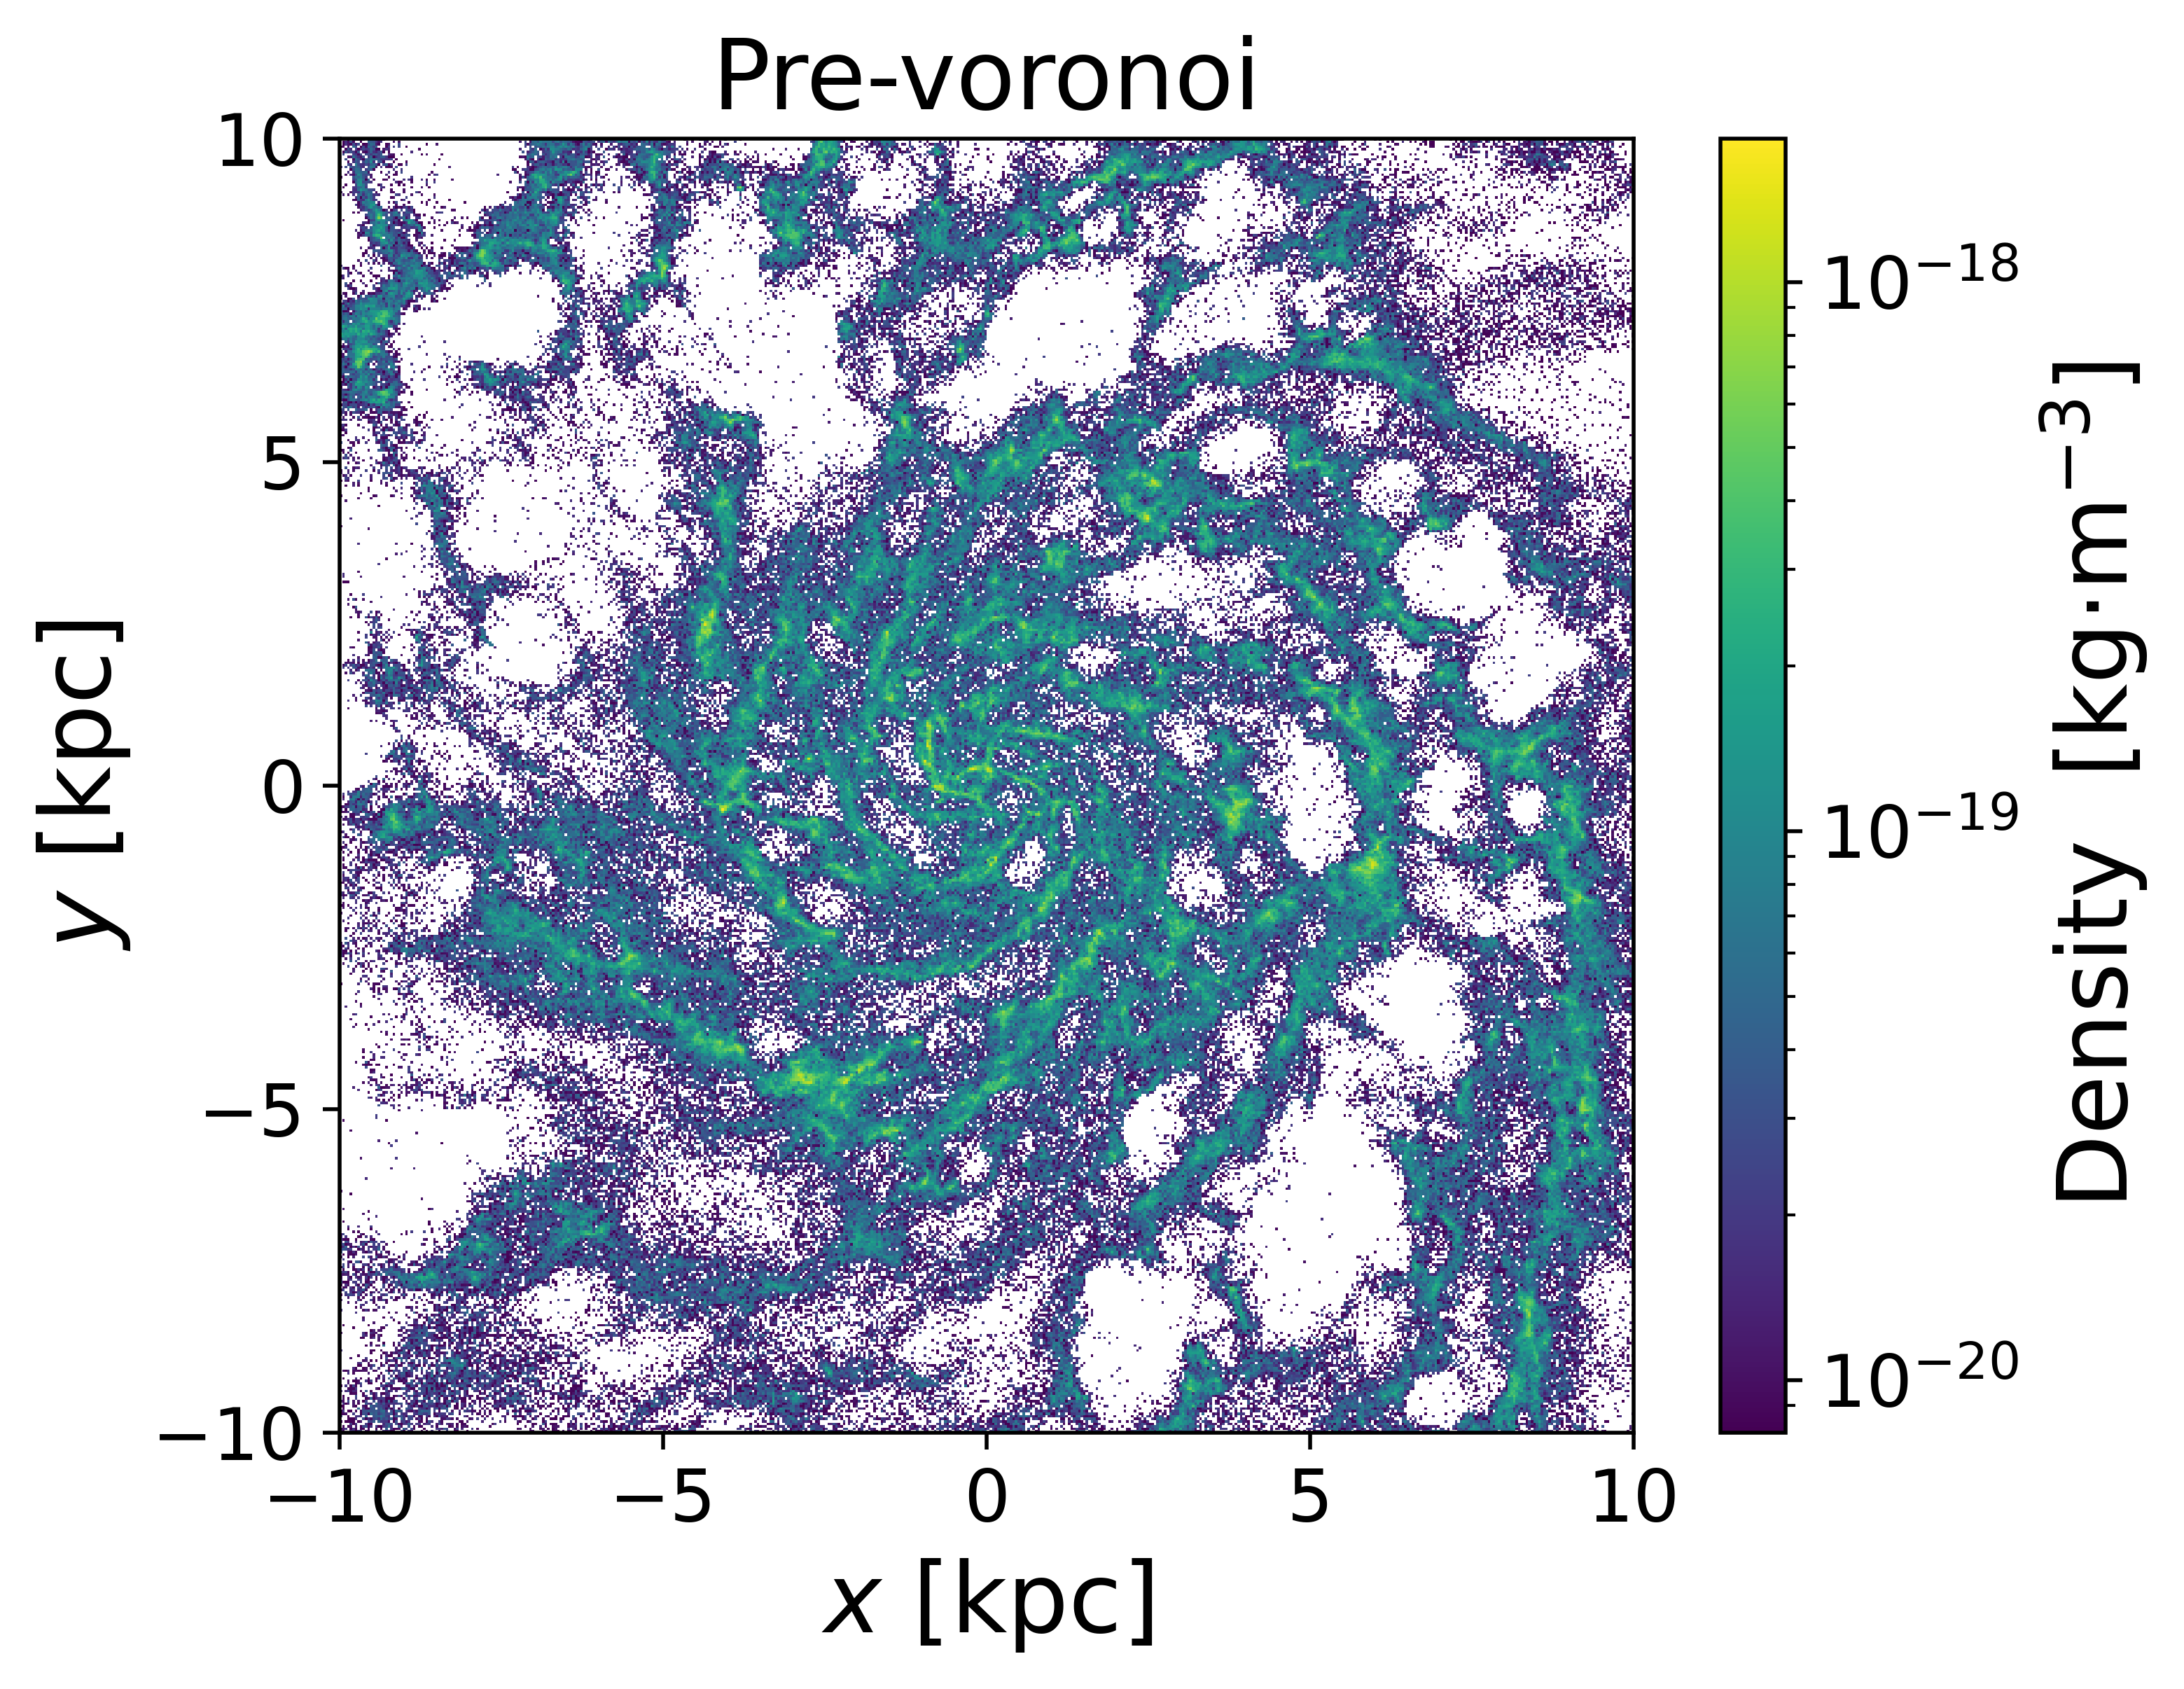

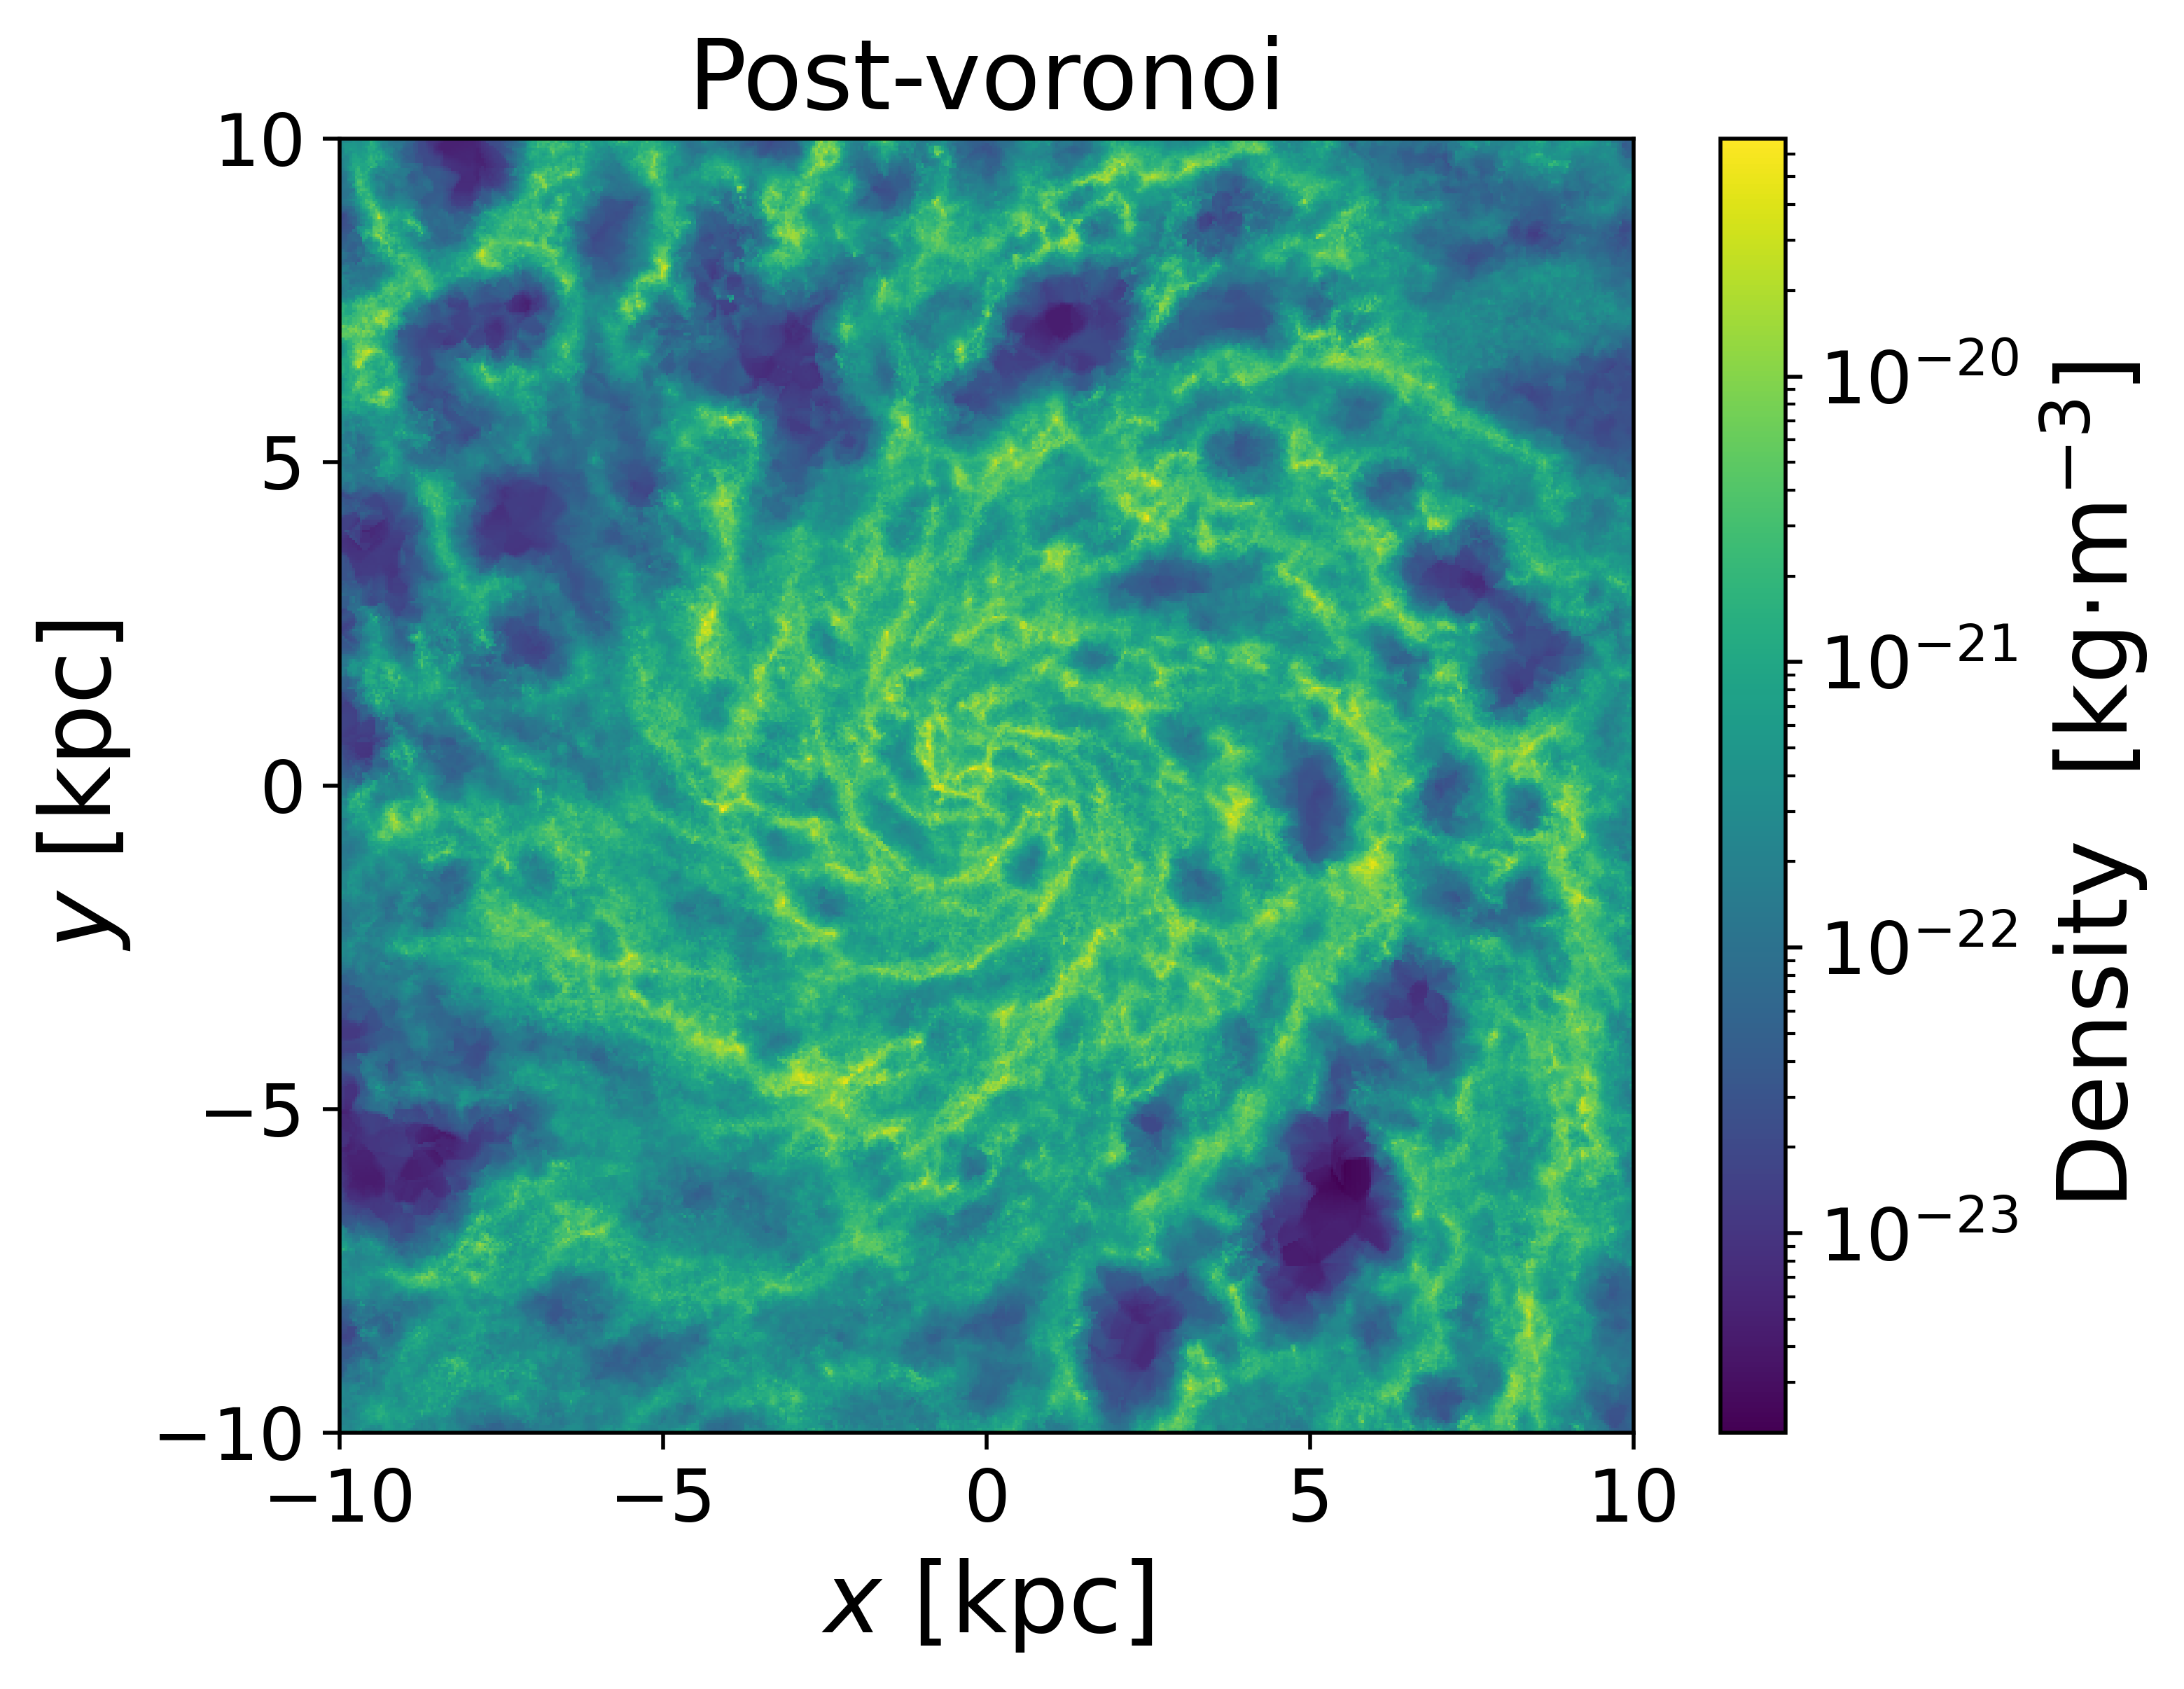

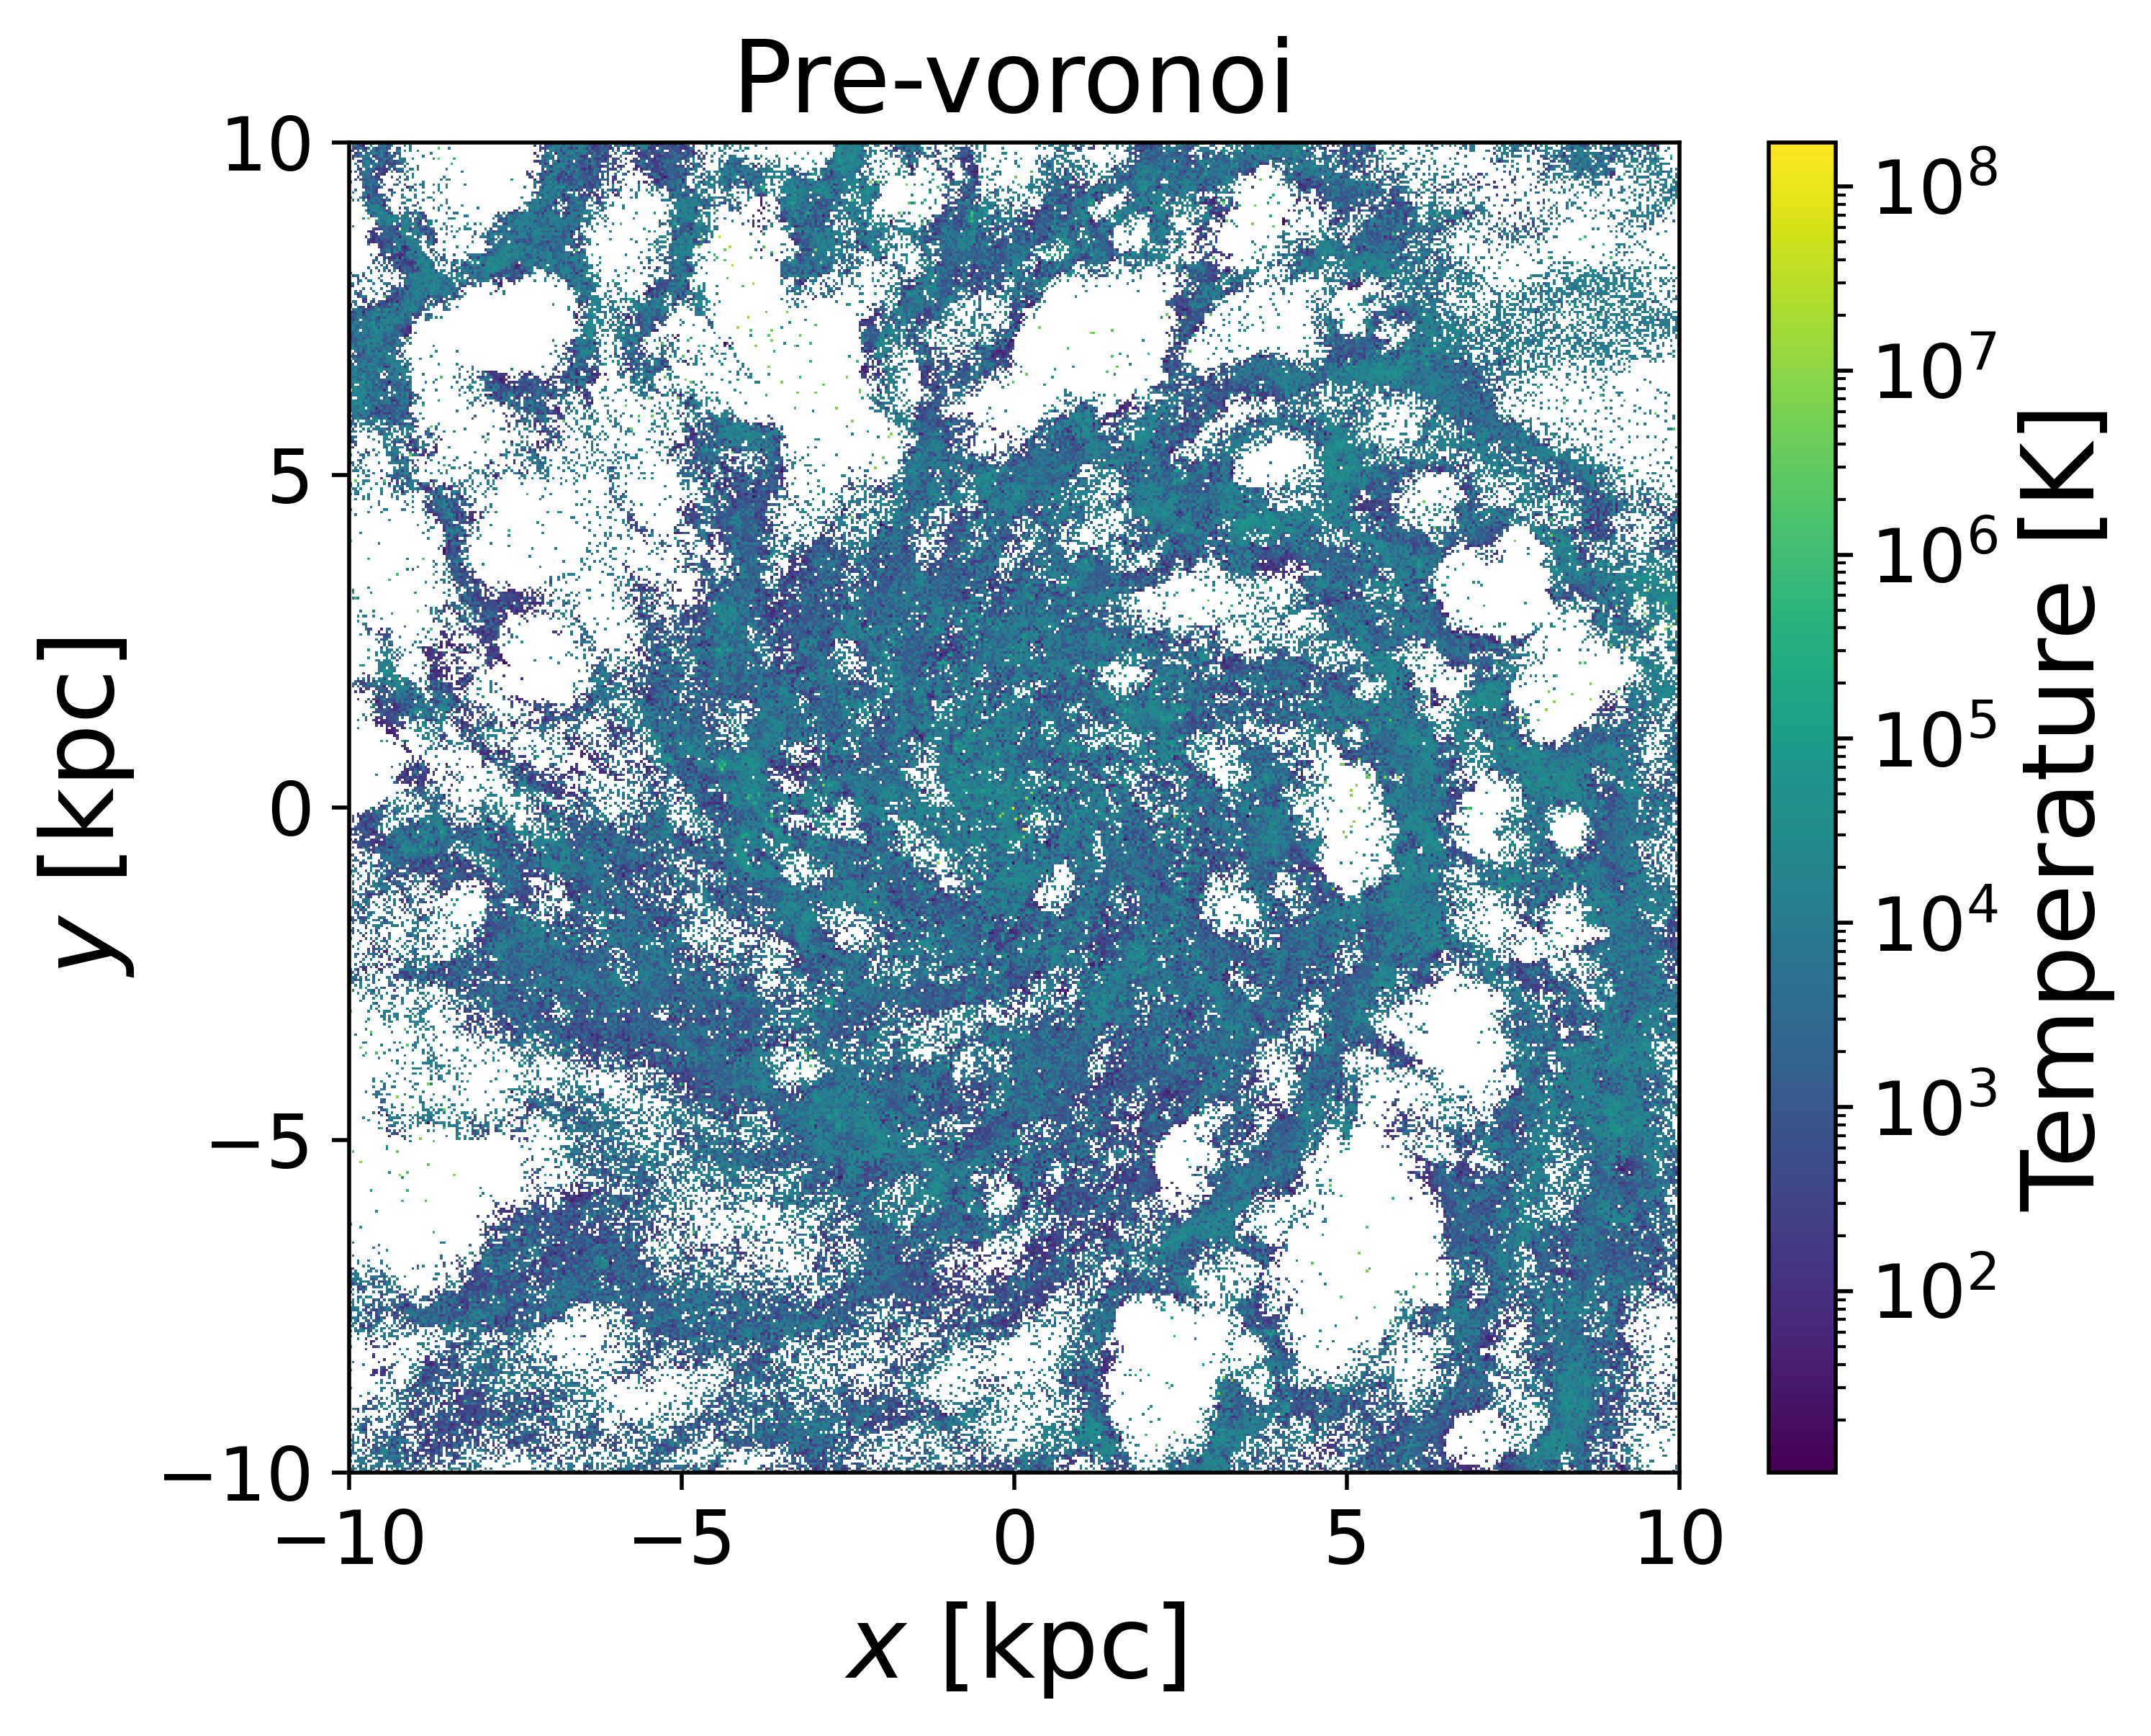

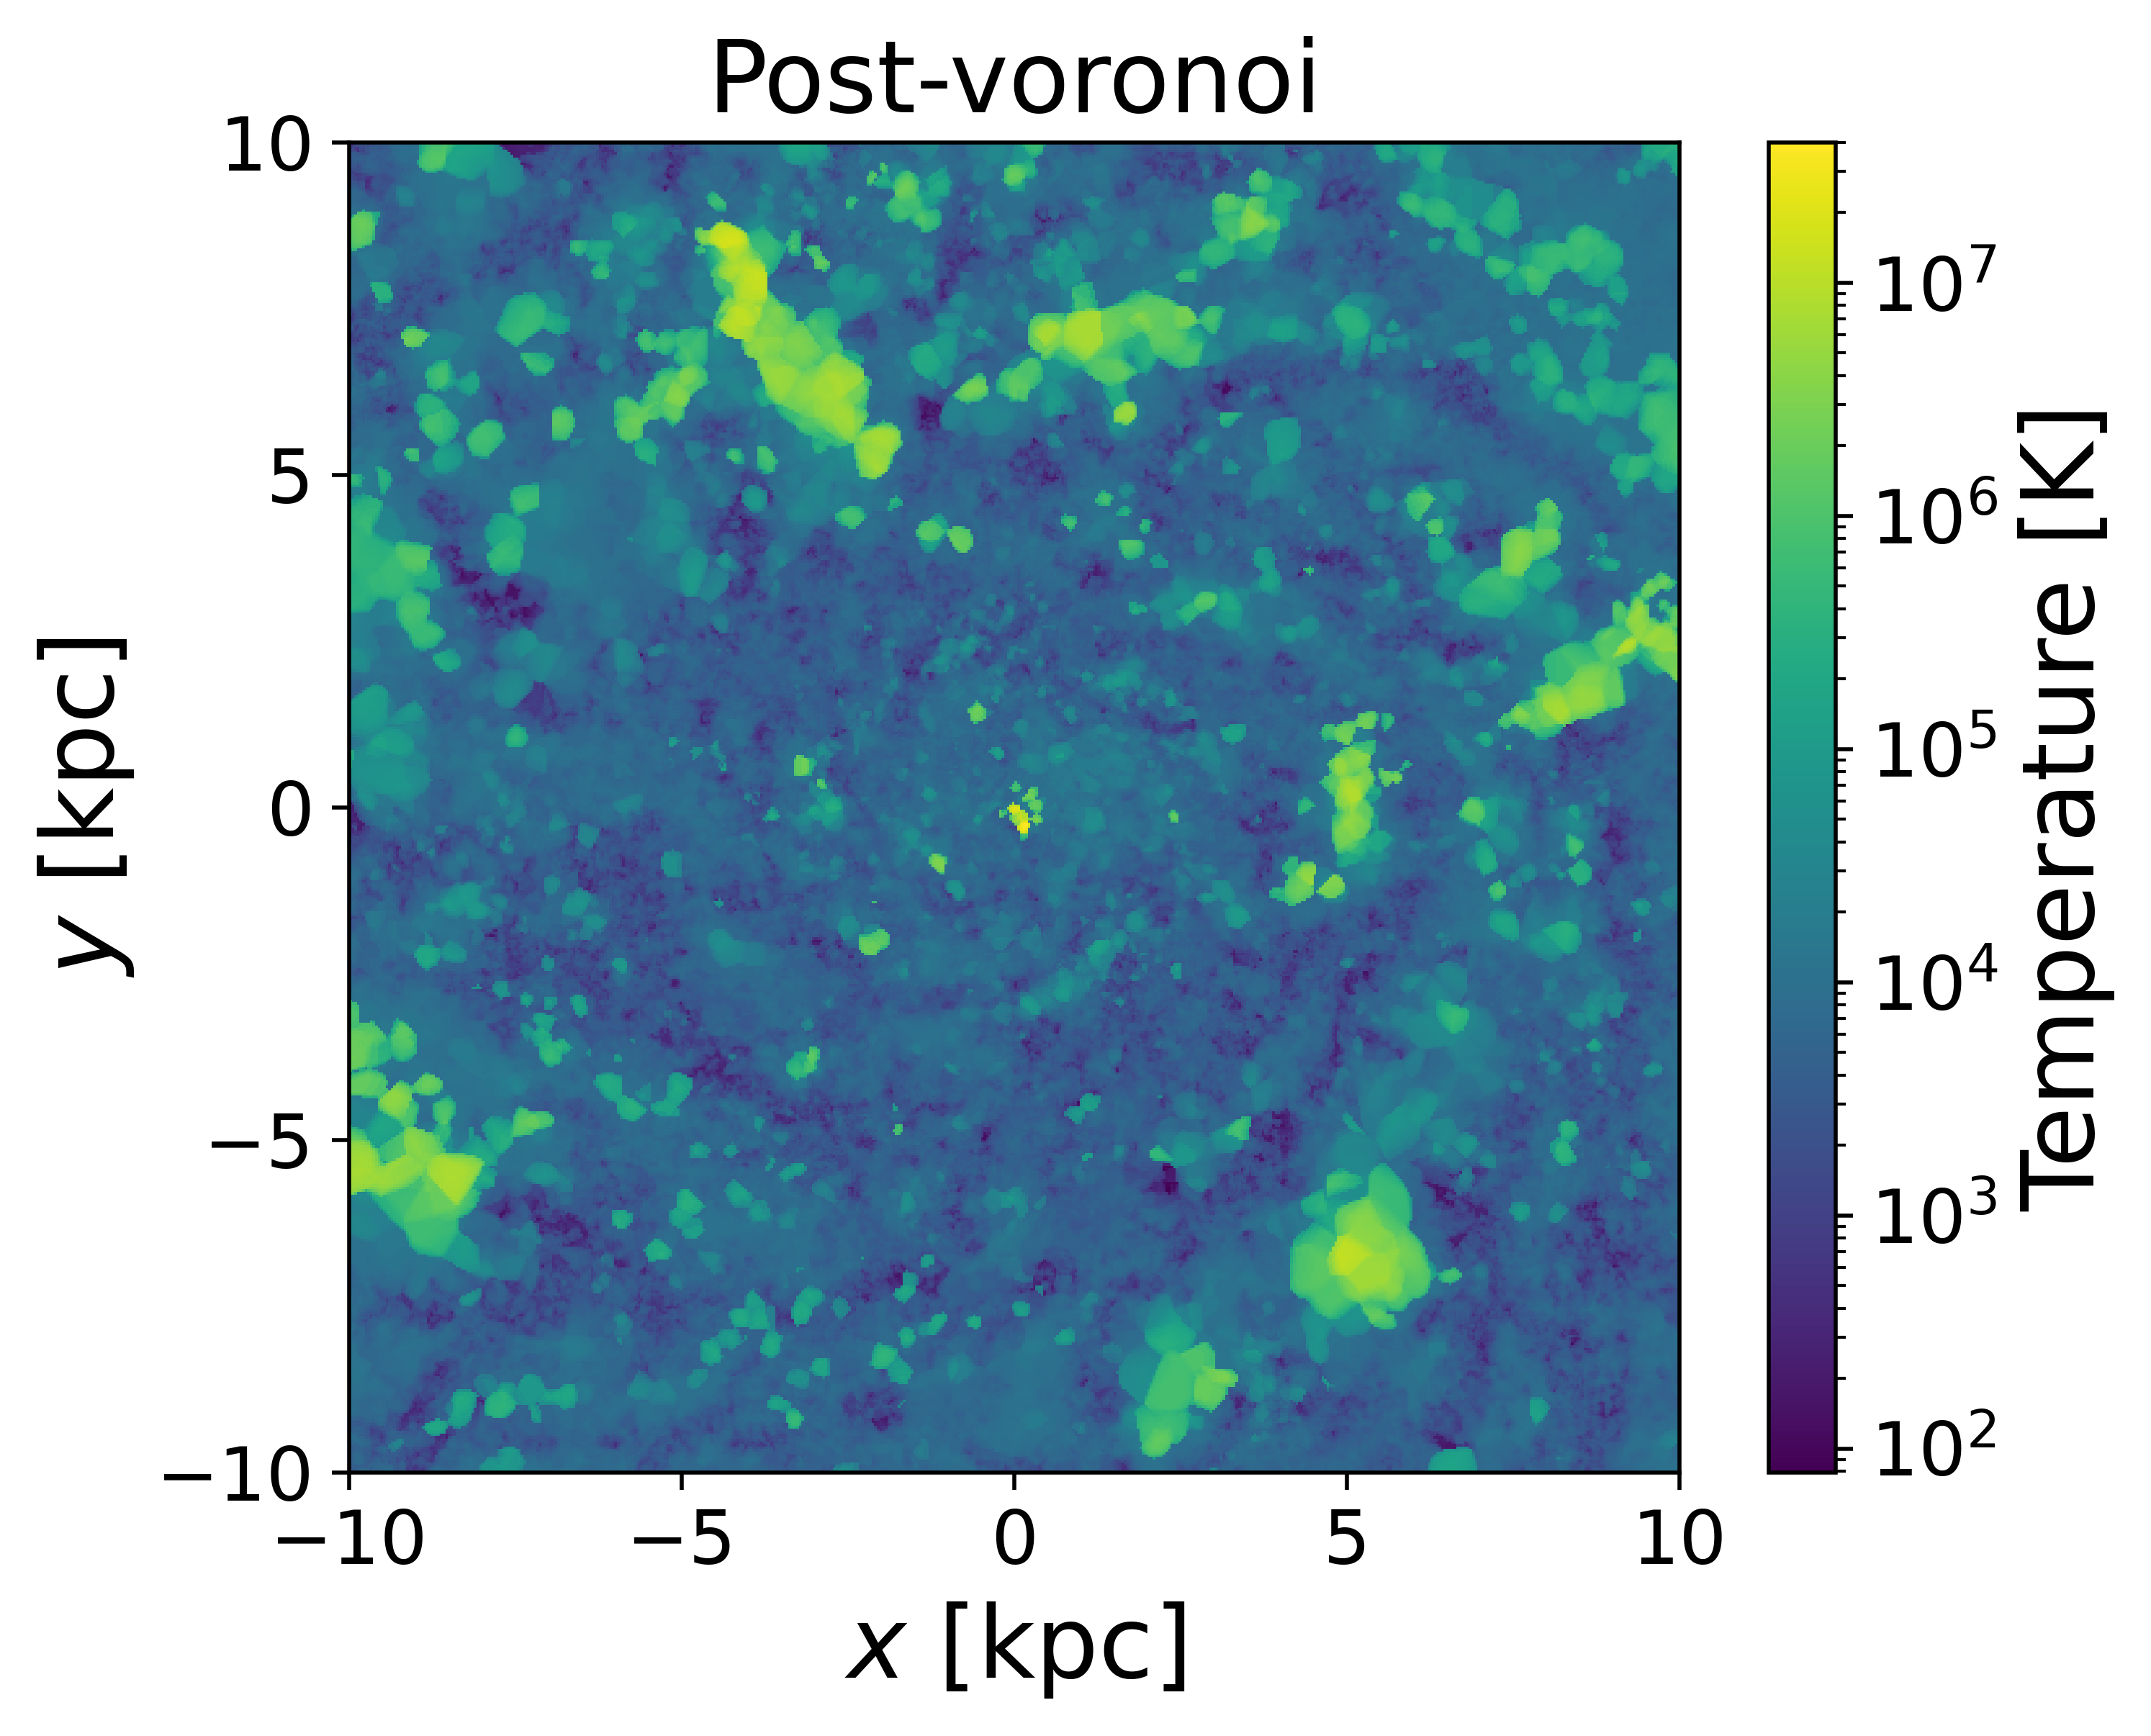

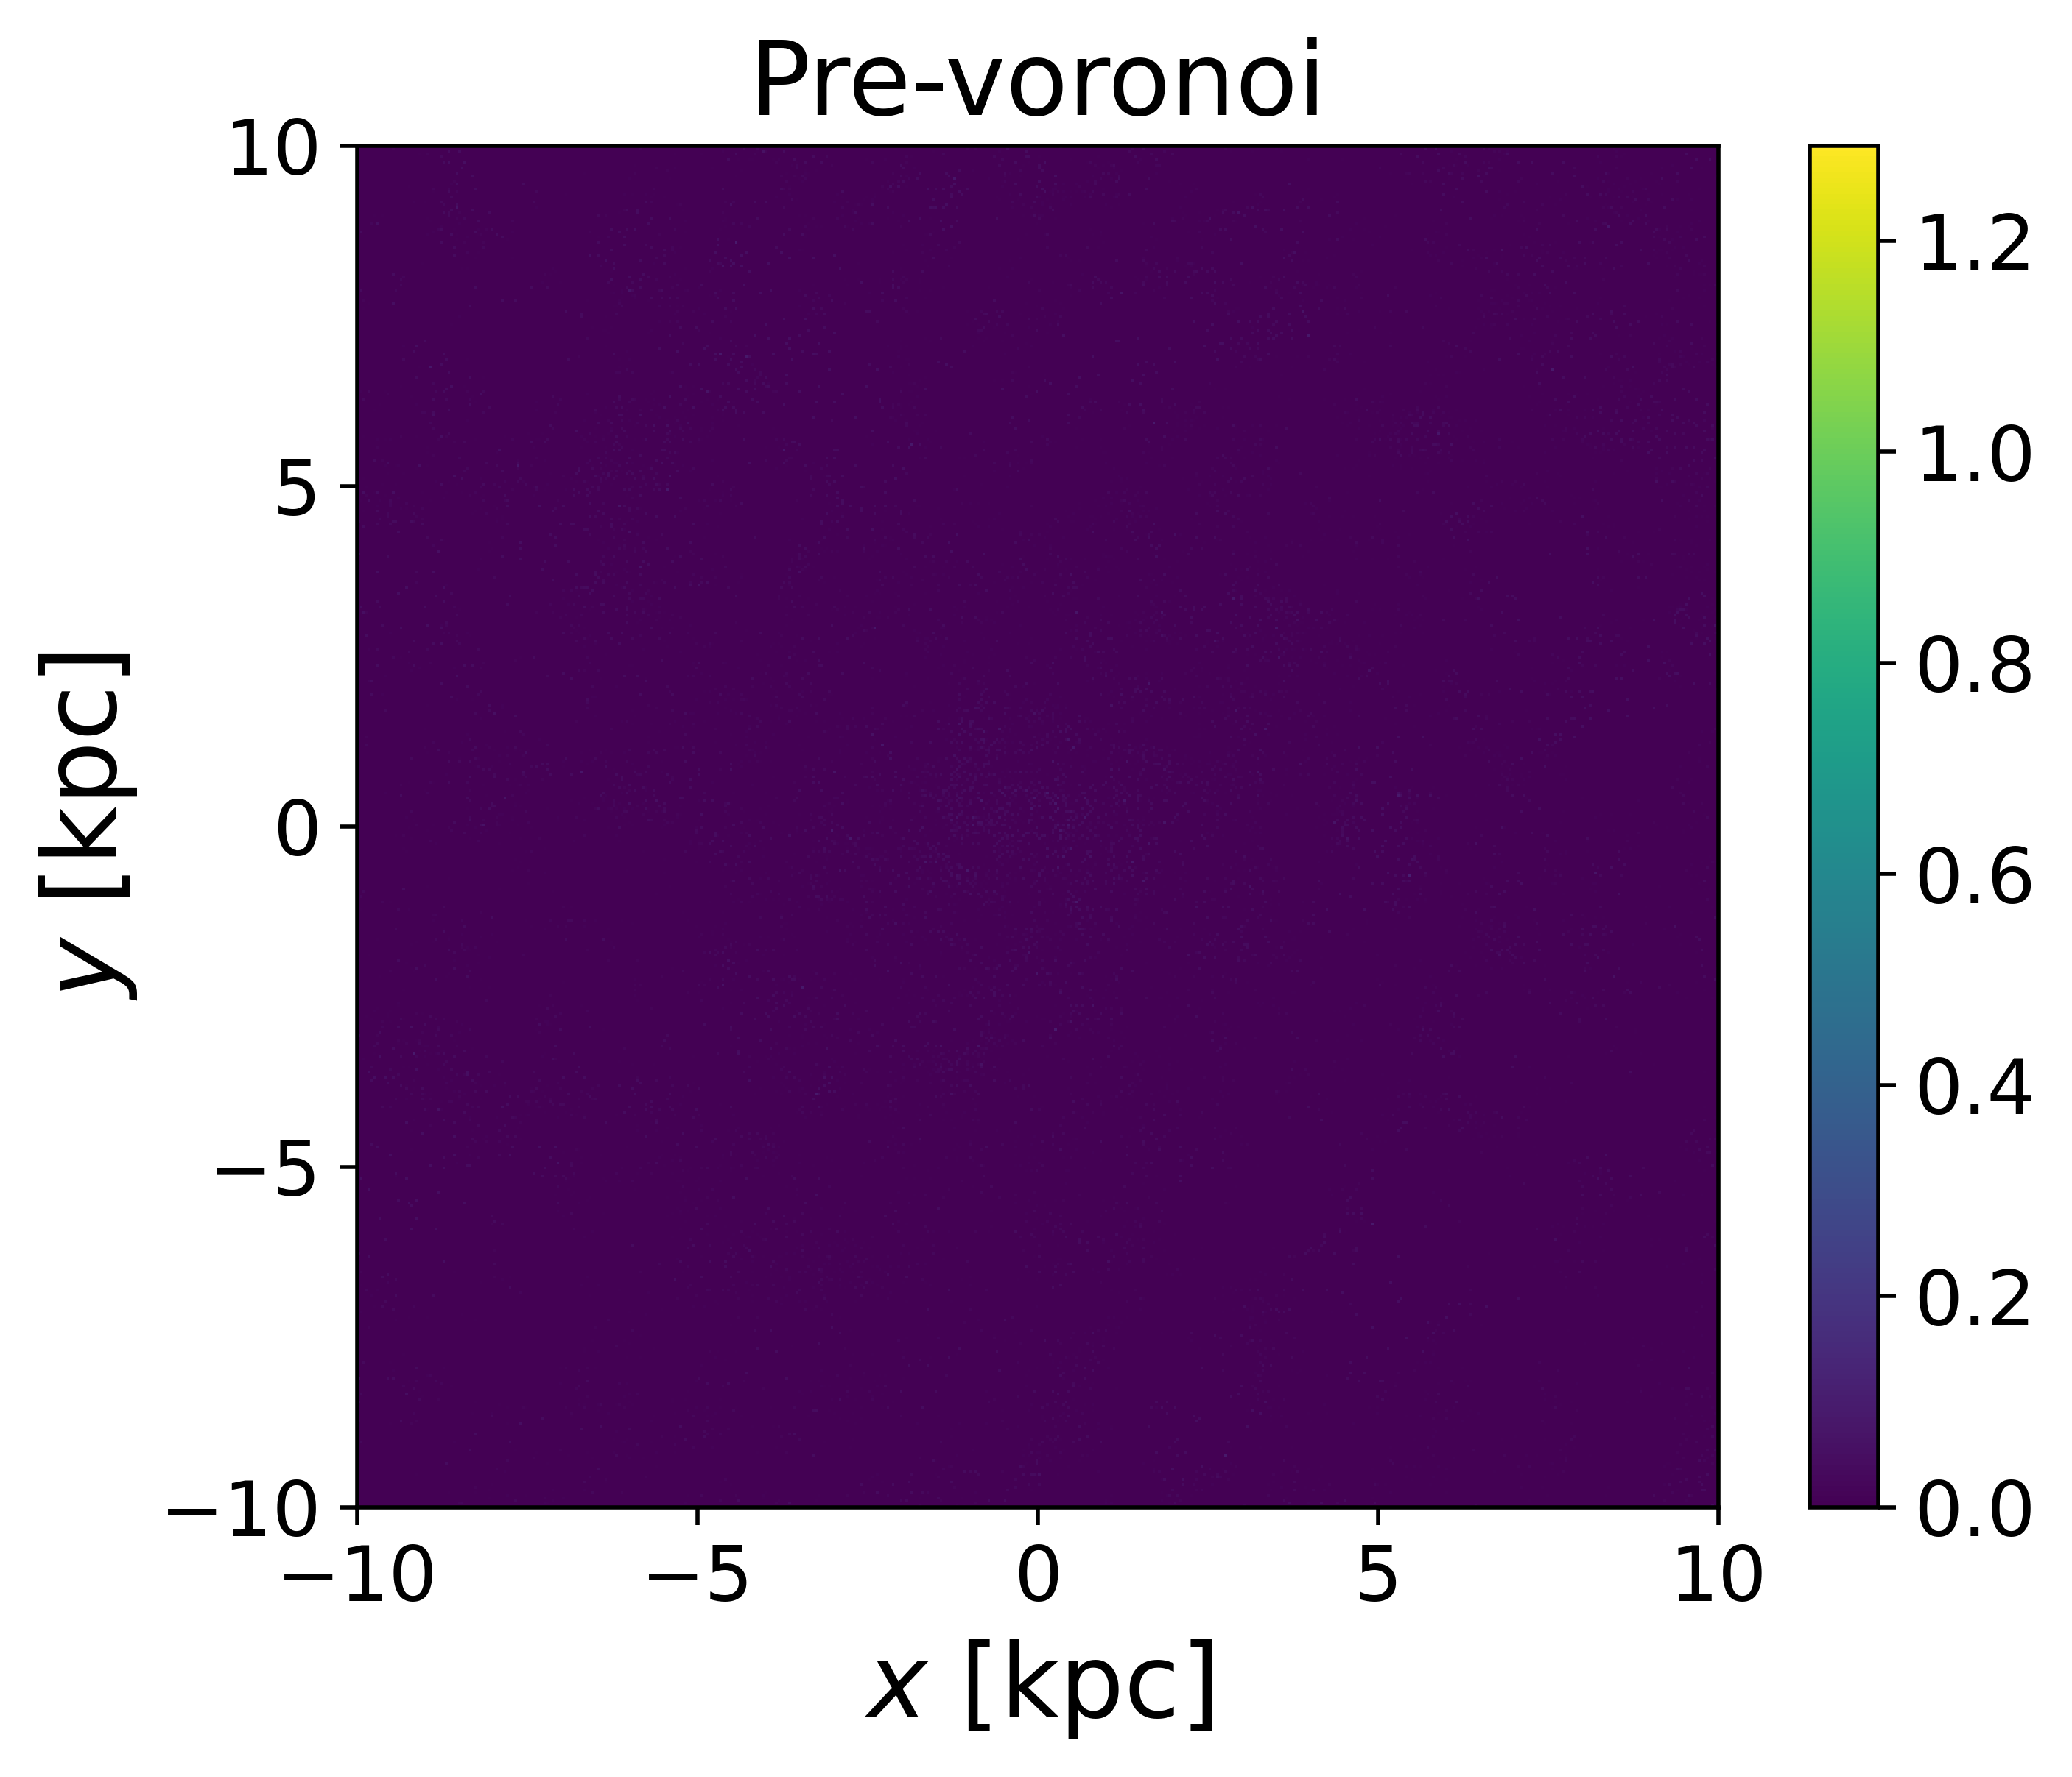

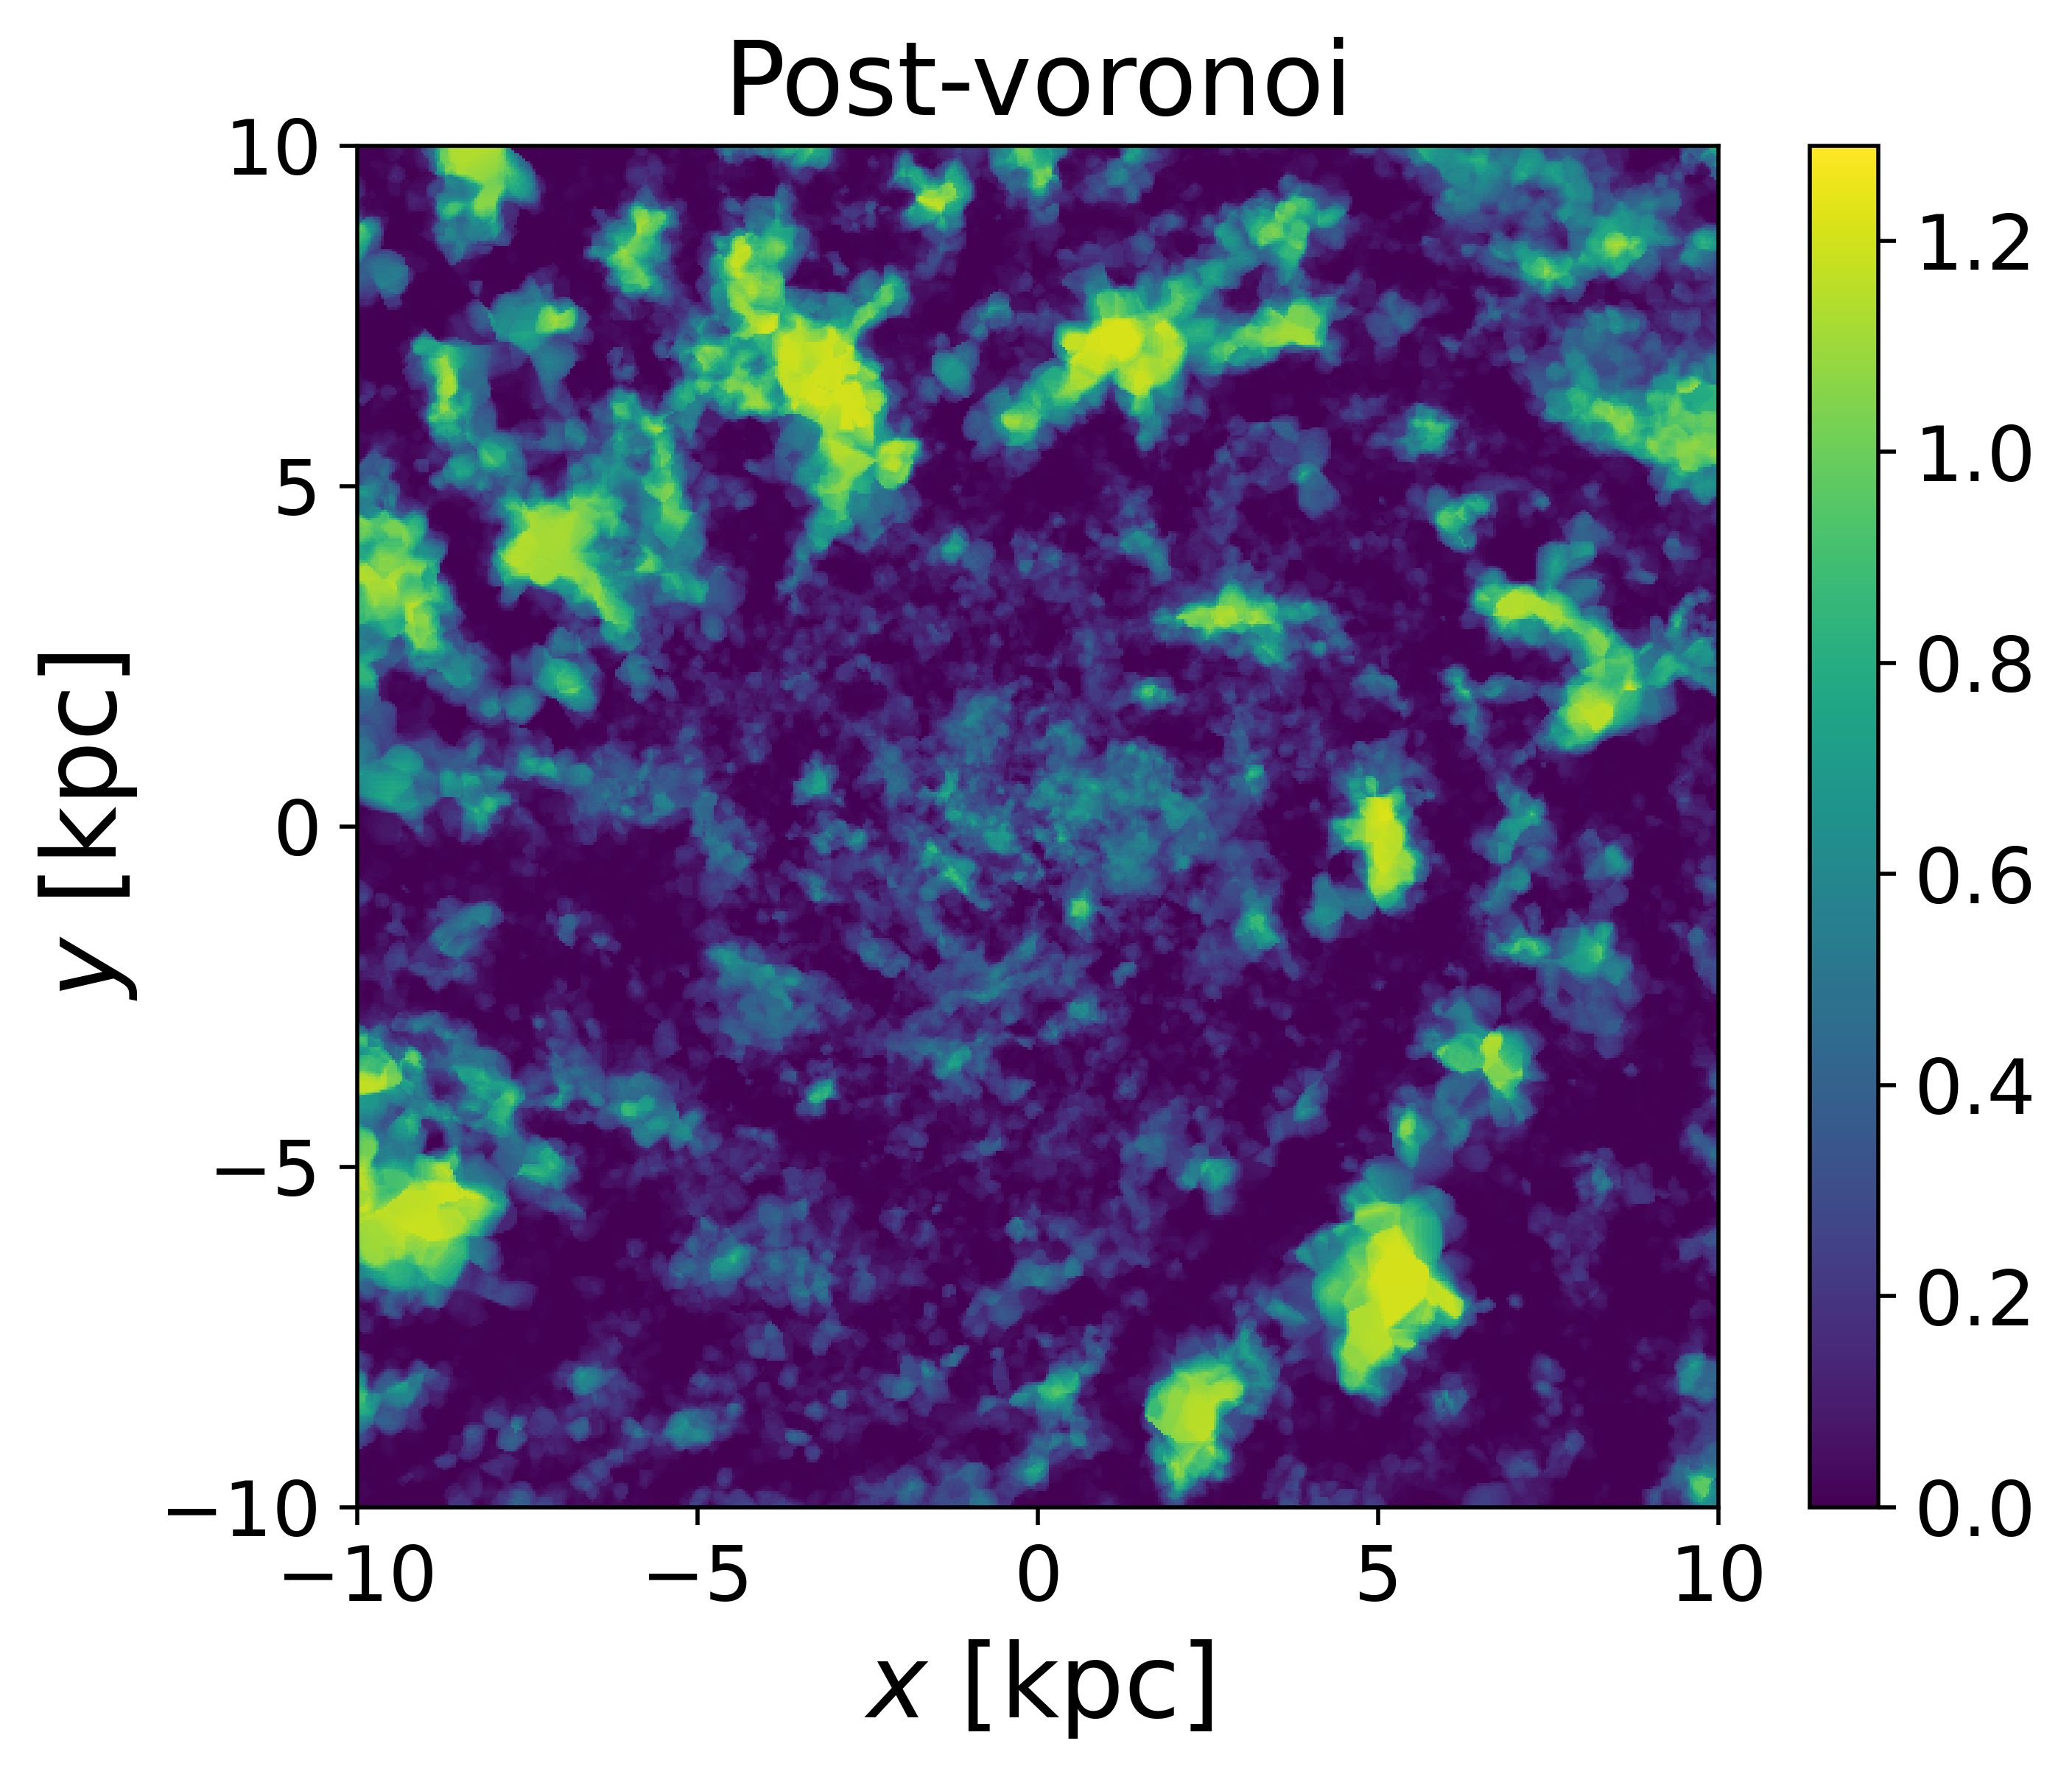

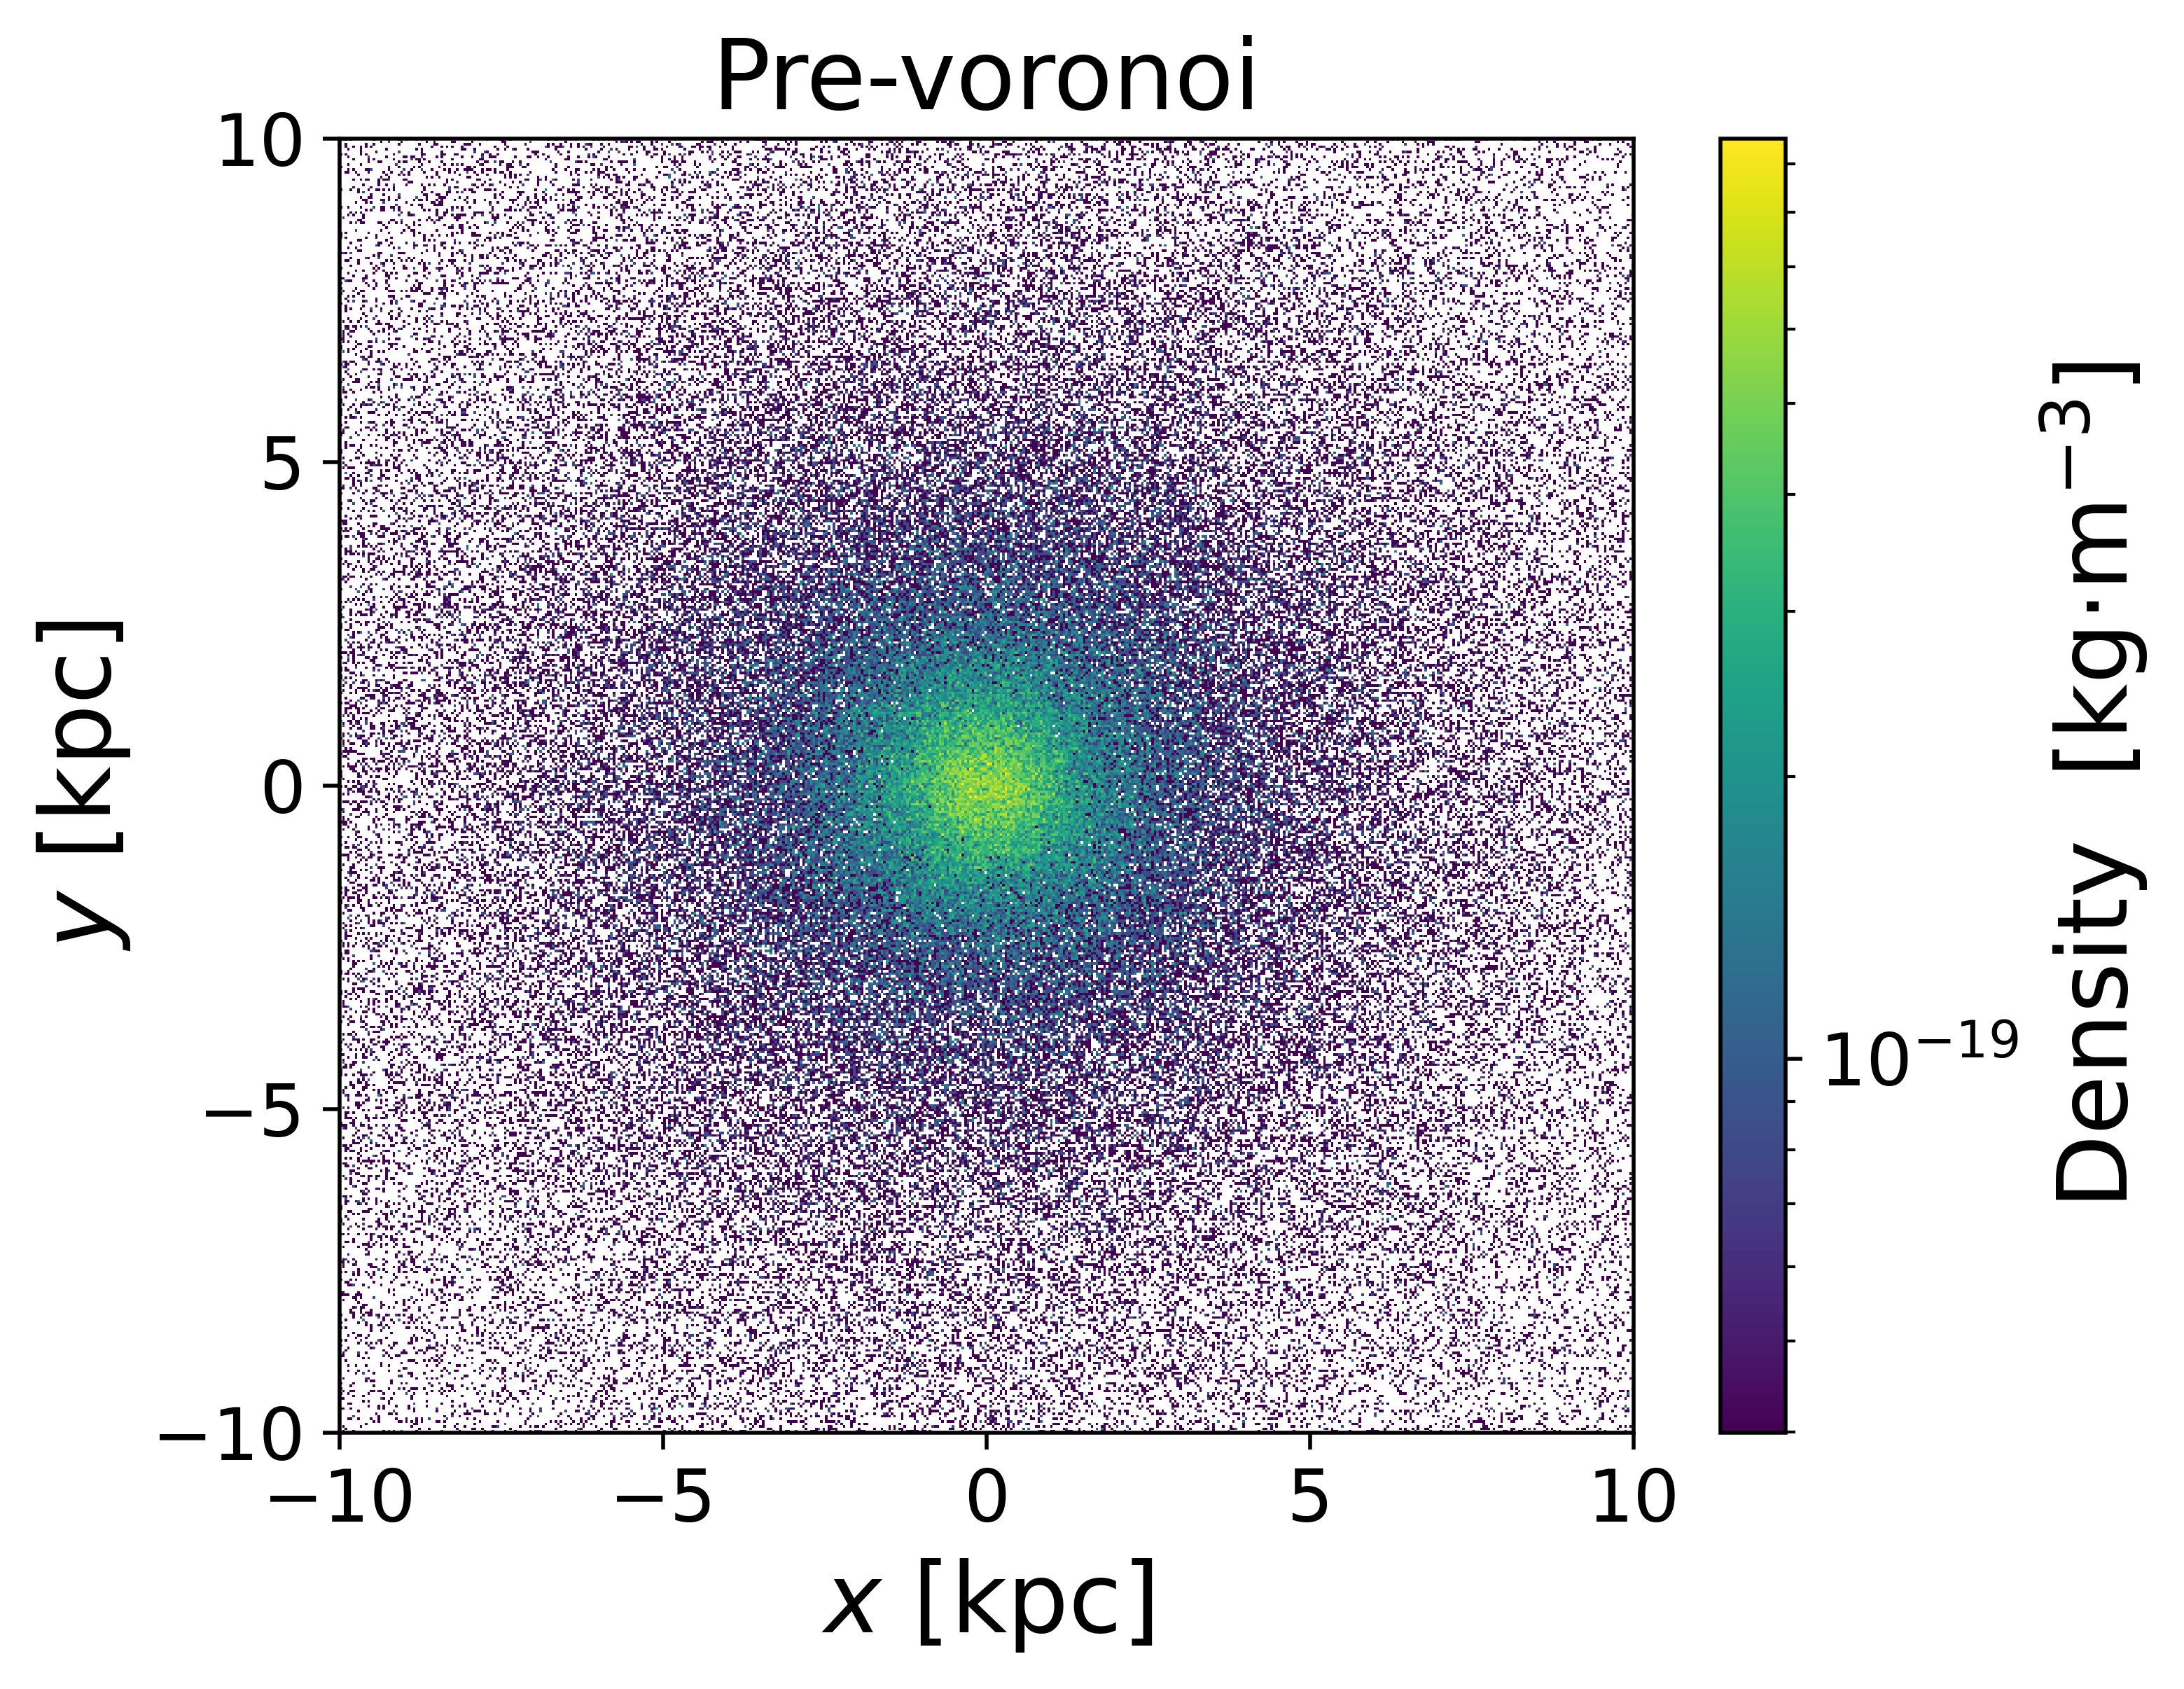

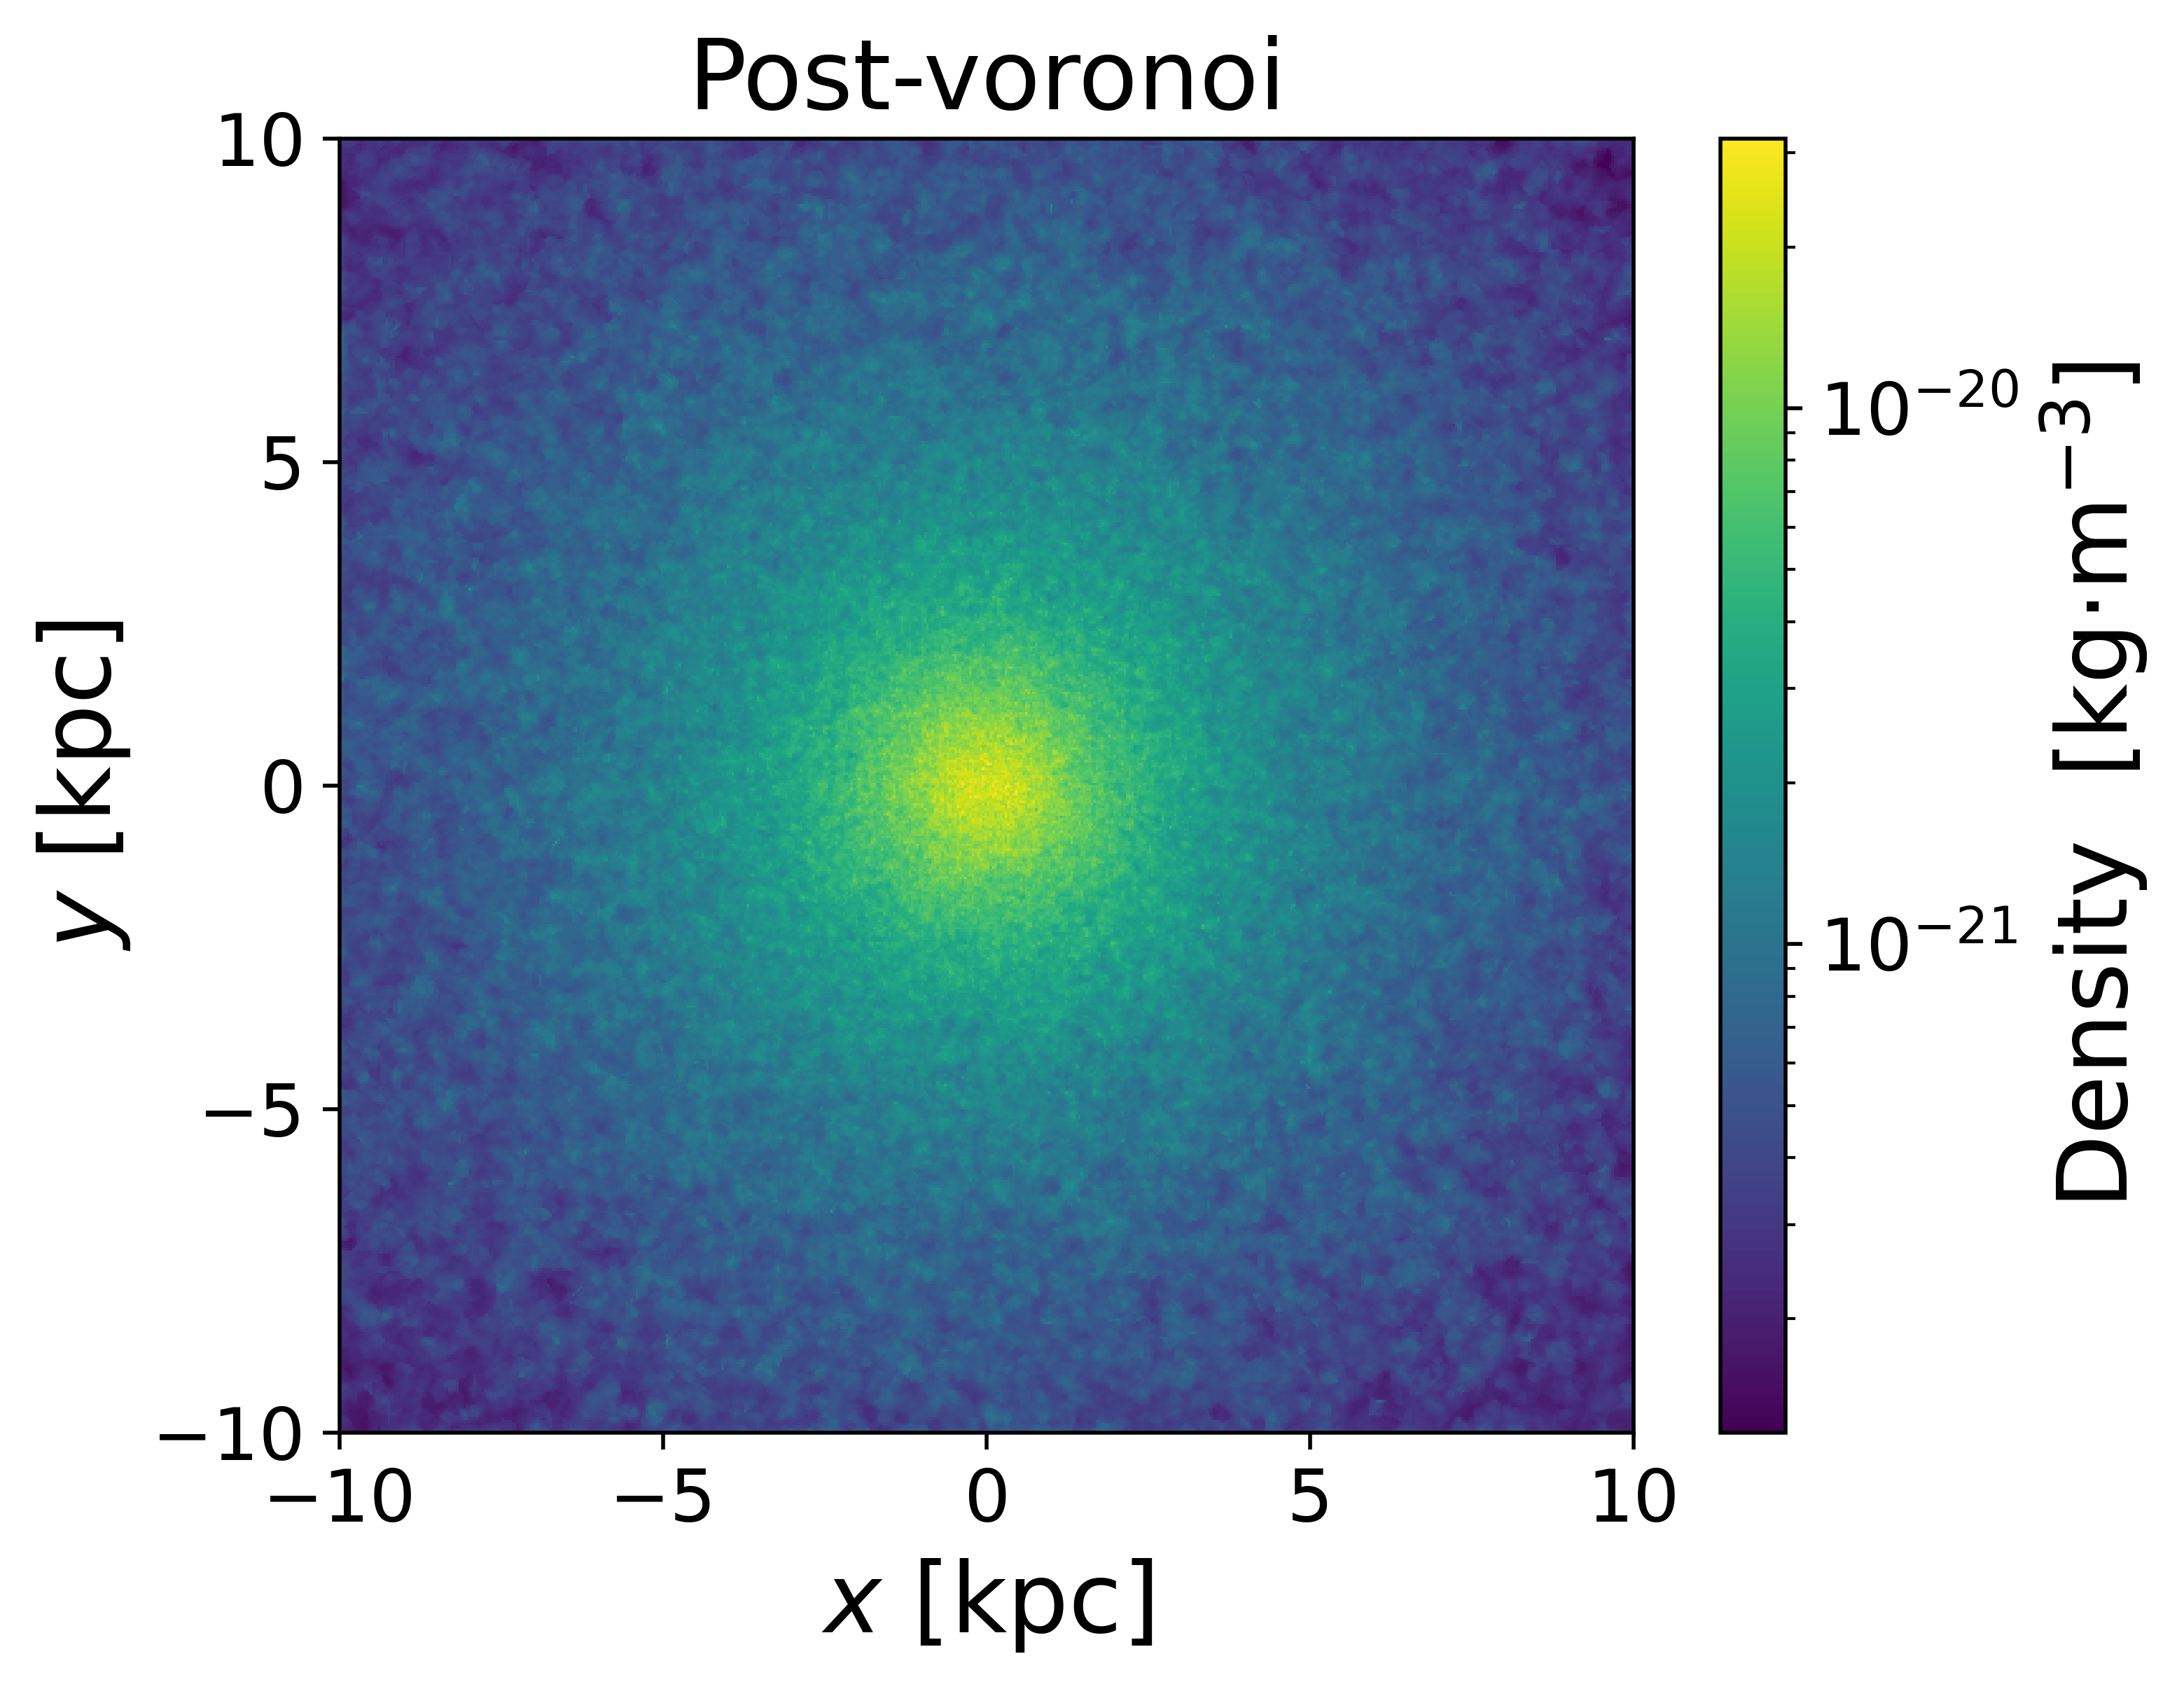

In [284]:
cubes = {}

# Final results:
advance()
grid_ids_dark = np.load('../data/FIRE/jan9/grid-ids--dark_mat-cKDTree.npy').astype(int)
advance()
grid_ids_gas = np.load('../data/FIRE/jan9/grid-ids--gas-cKDTree.npy').astype(int)
advance()

# ionized gas density
cubes["gas_density"] = compute_voronoi_cube_density(grid_c, grid_ids_gas, all_gas)
advance()
plot_pre_voronoi(all_gas["density"],         'Density  [kg$\cdot$m$^{-3}$]', "../visuals/jan9-voronoi-final-all_gas-density-pre")
advance()
plot_post_voronoi(cubes["gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/jan9-voronoi-final-all_gas-density-post")
advance()

# ionized gas temperature
cubes["gas_temp"] = compute_voronoi_cube_temp(grid_c, grid_ids_gas, all_gas)
advance()
plot_pre_voronoi(all_gas["binned_temp"],   'Temperature [K]', "../visuals/jan9-voronoi-final-all_gas-temp-pre")
advance()
plot_post_voronoi(cubes["gas_temp"],    'Temperature [K]', "../visuals/jan9-voronoi-final-all_gas-temp-post")
advance()

# ionized gas temperature
cubes["gas_efrac"] = compute_voronoi_cube_efrac(grid_c, grid_ids_gas, all_gas)
advance()
plot_pre_voronoi_efrac(all_gas["binned_efrac"]*u.dimensionless_unscaled,   '', "../visuals/jan9-voronoi-final-all_gas-efrac-pre")
advance()
plot_post_voronoi_efrac(cubes["gas_efrac"]*u.dimensionless_unscaled,    '', "../visuals/jan9-voronoi-final-all_gas-efrac-post")
advance()

# dark matter density
cubes["dark_mat_density"] = compute_voronoi_cube_density(grid_c, grid_ids_dark, dark_mat)
advance()
plot_pre_voronoi(dark_mat["density"],         'Density  [kg$\cdot$m$^{-3}$]', "../visuals/jan9-voronoi-final-dark_mat-density-pre")
advance()
plot_post_voronoi(cubes["dark_mat_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/jan9-voronoi-final-dark_mat-density-post")
advance()

In [224]:
np.max(efrac)

1.2942605400069829

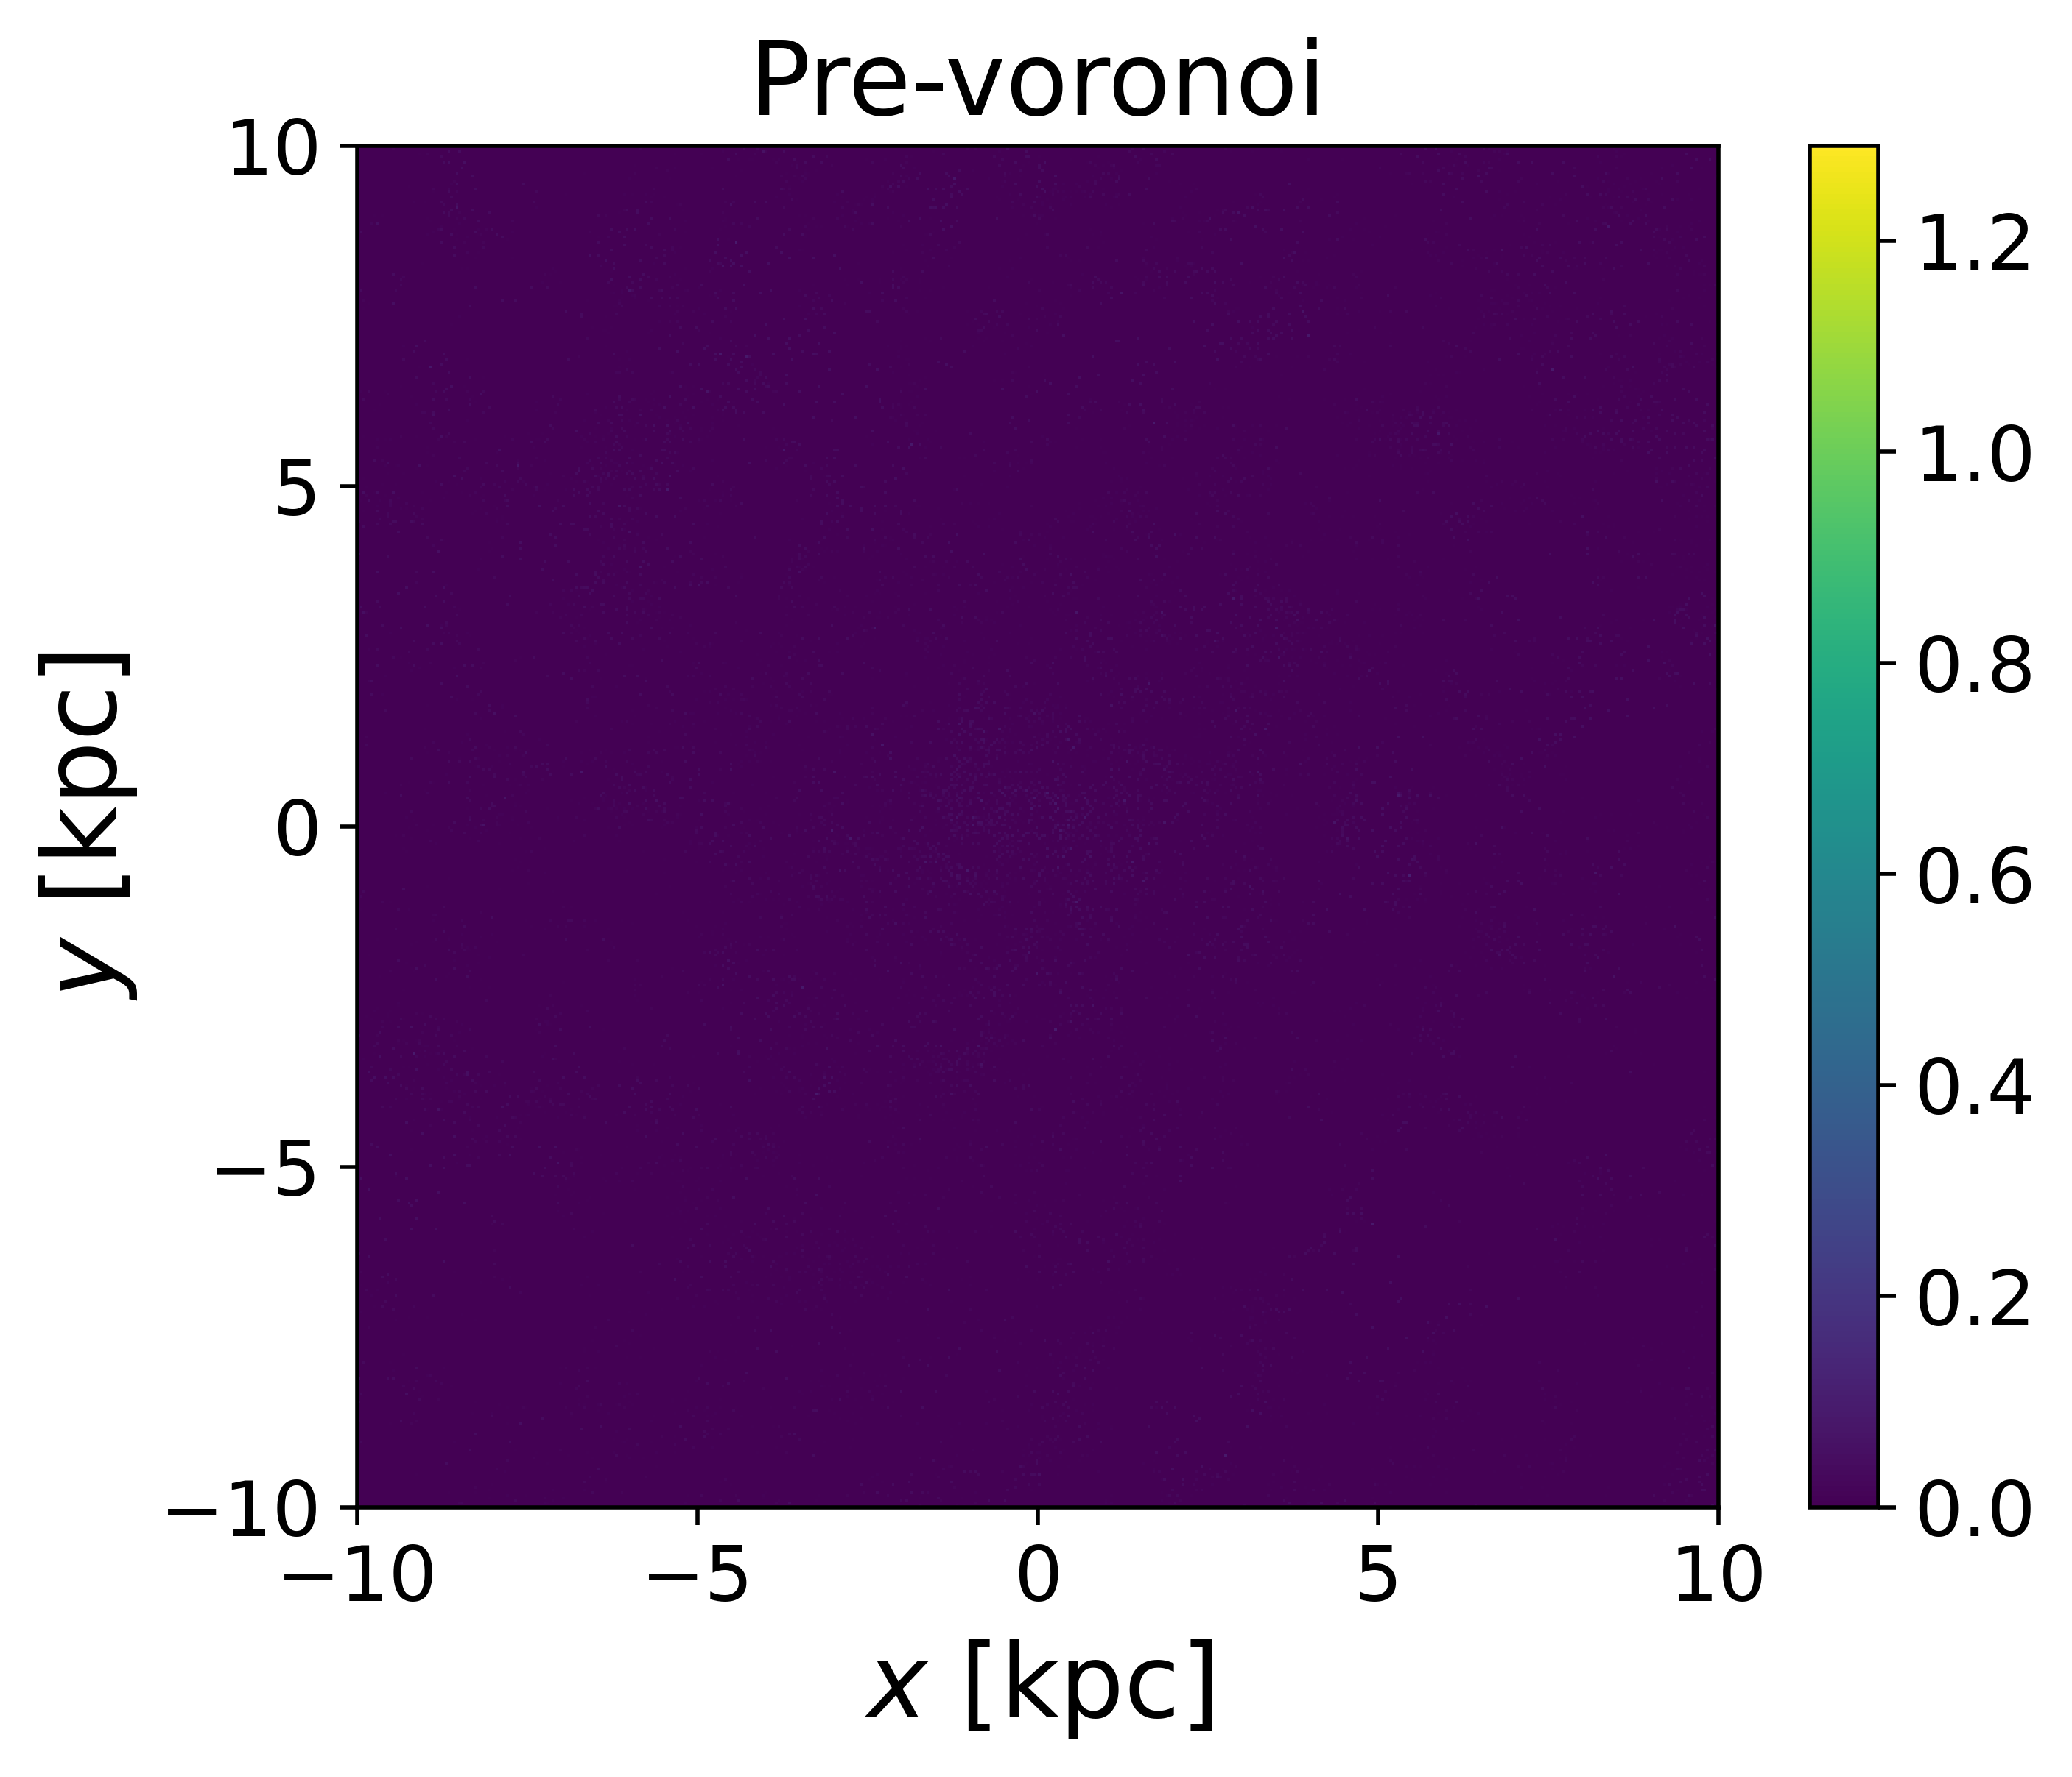

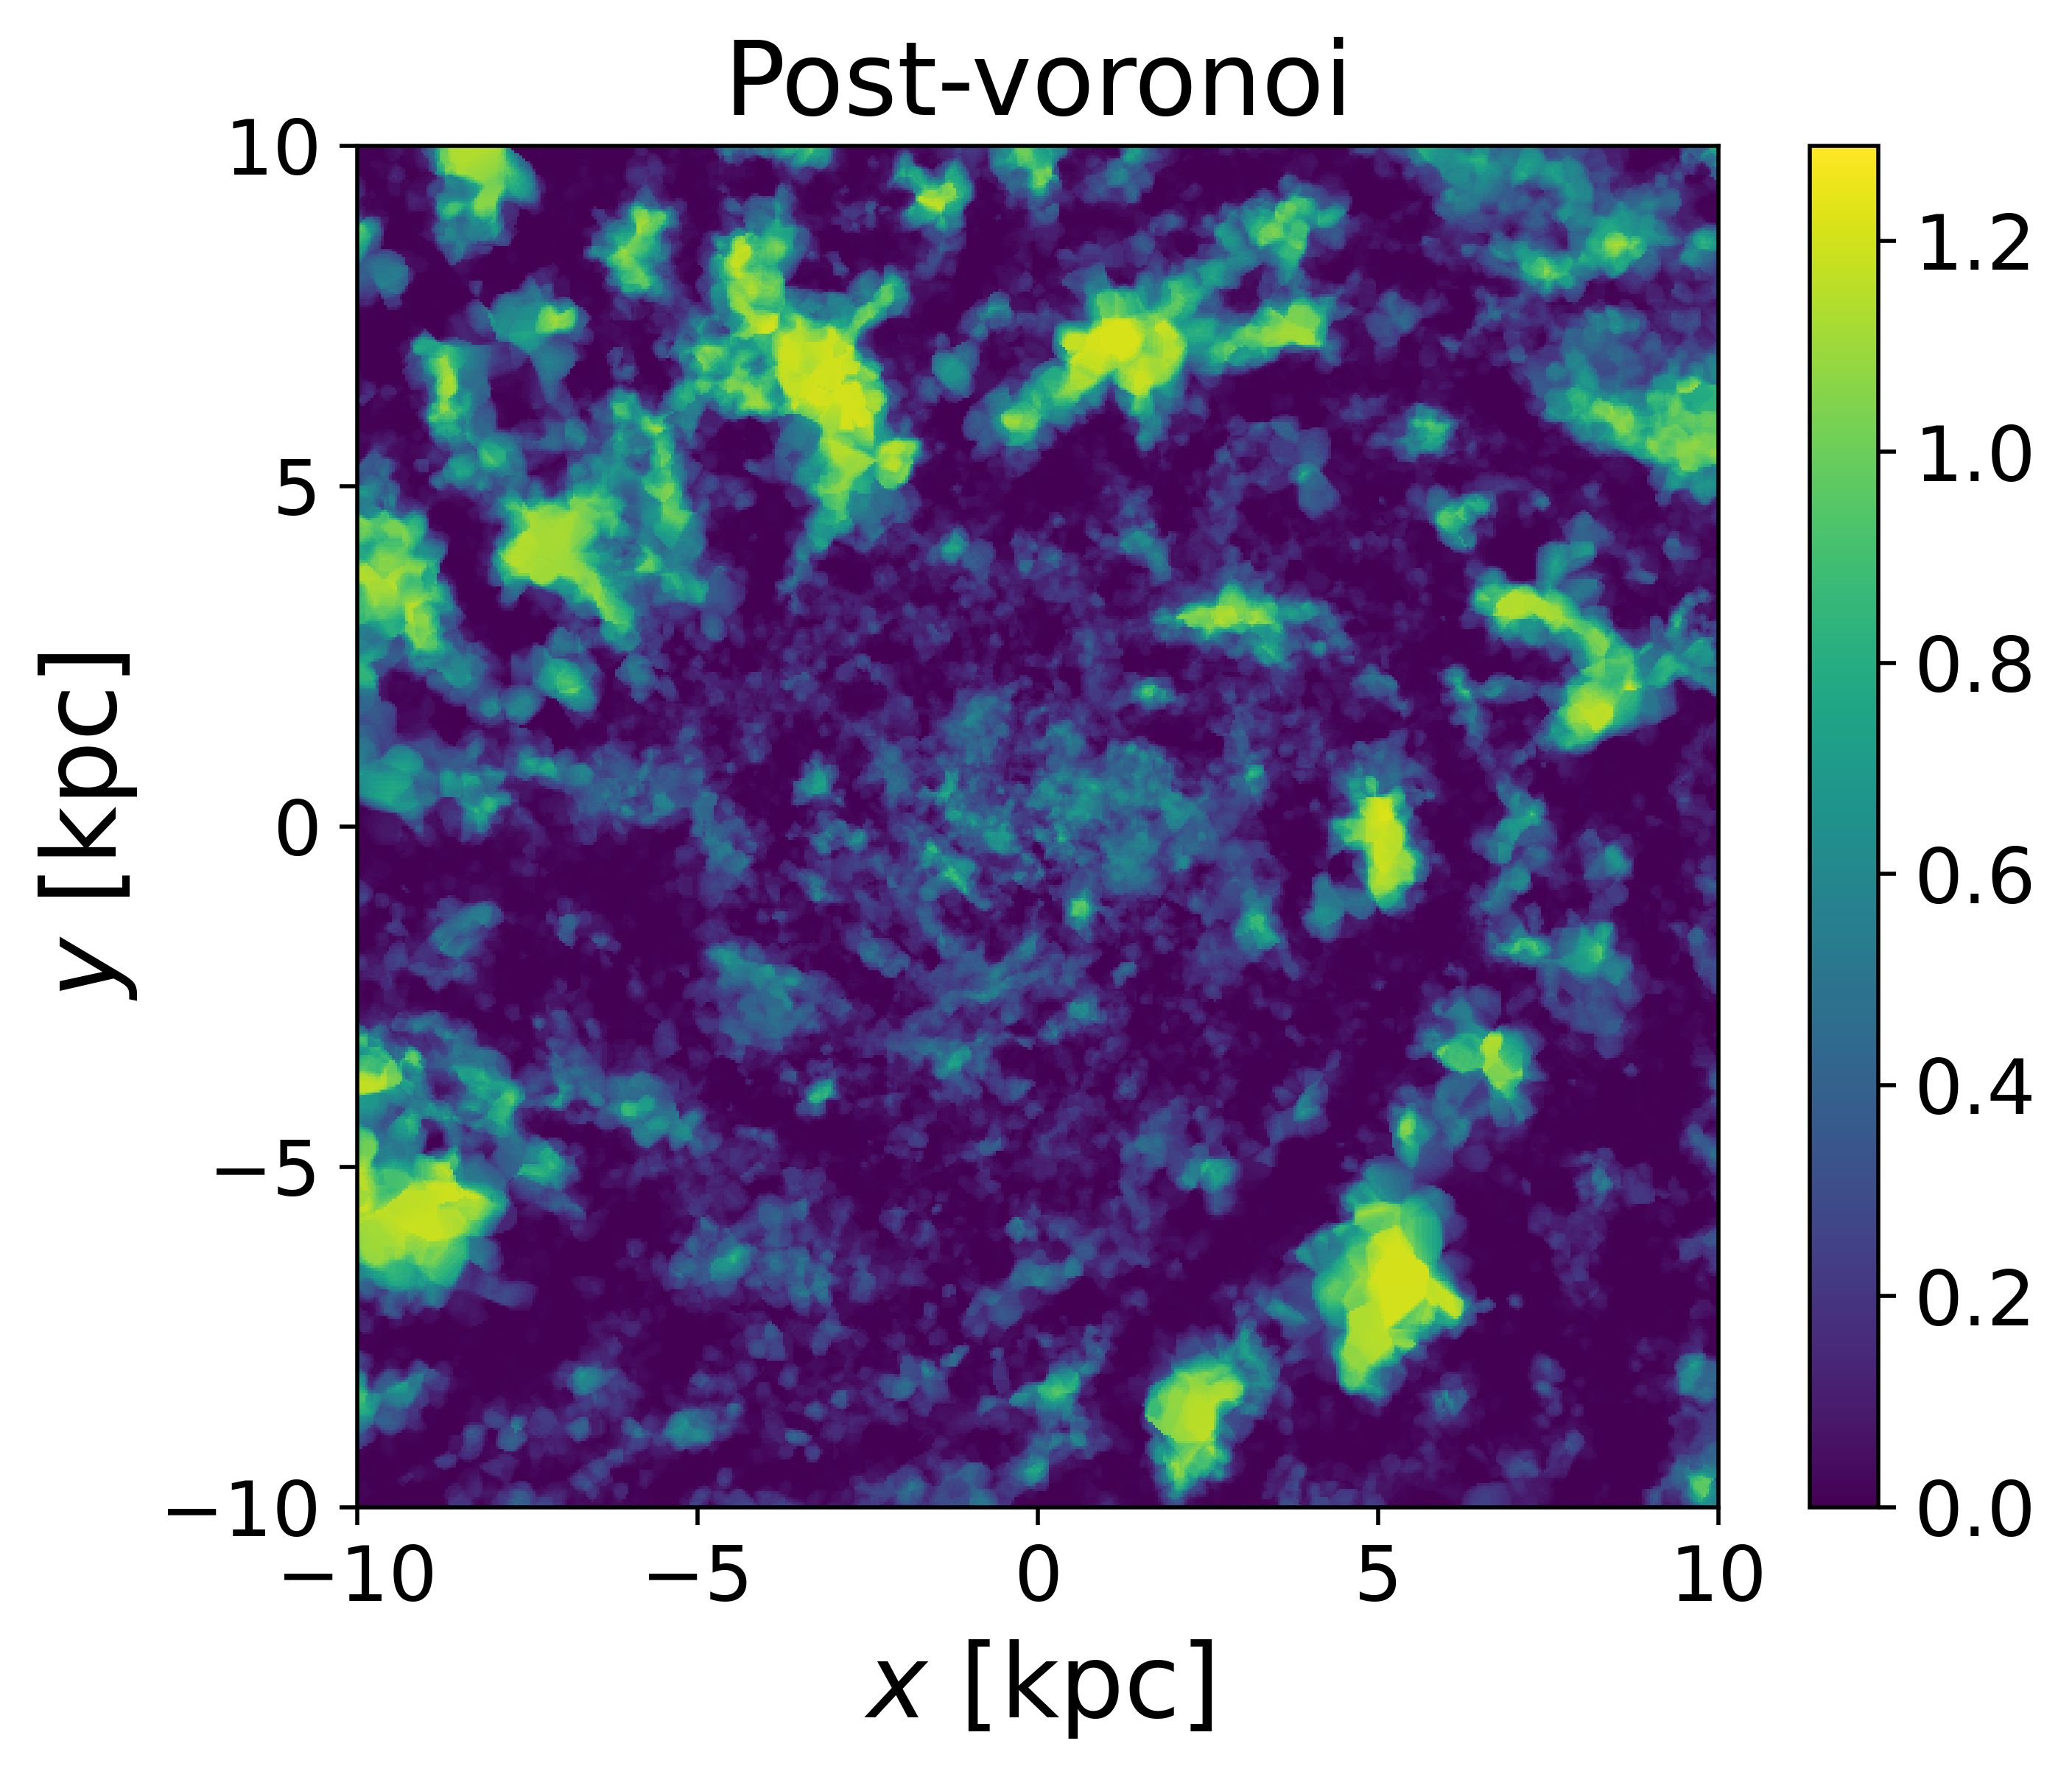

In [279]:



plot_pre_voronoi_efrac(all_gas["binned_efrac"]*u.dimensionless_unscaled,   '', "../visuals/jan9-voronoi-final-all_gas-temp-pre")
advance()
plot_post_voronoi_efrac(cubes["gas_efrac"]*u.dimensionless_unscaled,    '', "../visuals/jan9-voronoi-final-all_gas-temp-post")

In [203]:
cubes.keys()

dict_keys(['gas_density', 'gas_temp', 'gas_efrac', 'dark_mat_density'])

In [222]:
savee = True
if savee:
    counter = np.array([0])
    m = len(cubes.keys())
    advance()
    for cube in cubes:
        if cube != "gas_efrac":
            np.save("../data/FIRE/jan9/cubes/cube-"+cube+".npy", cubes[cube].value)
        else:
            np.save("../data/FIRE/jan9/cubes/cube-"+cube+".npy", cubes[cube])
        advance()

In [43]:
DENSITY = np.sum(dark_mat["density"])
print(f">> checking total dark matter density:")
print(f"  >> argmin:\t{np.sum(voronoied_result_1)}\n  >> cKDTree:\t{np.sum(voronoied_result_2)}\n  >> true:\t{DENSITY}")
SUM = np.sum(cubes["dark_mat_density"])
print(f"  >> test\t{SUM}")
print(f"  >> diff ids:\t{(grid_ids_1 - grid_ids_2 != 0).sum()}/{len(grid_ids_1)} = {(grid_ids_1 - grid_ids_2 != 0).sum()/len(grid_ids_1)*100}%")

>> checking total dark matter density:


NameError: name 'voronoied_result_1' is not defined

In [33]:
DENSITY = np.sum(dark_mat["density"])
print(f">> checking total dark matter density:")
print(f"  >> true:\t{DENSITY}")
SUM = np.sum(cubes["dark_mat_density"])
print(f"  >> test\t{SUM}")


>> checking total dark matter density:
  >> true:	7.716210104544625e-14 kg / m3
  >> test	7.716210104544614e-14 kg / m3


<Quantity 1.35124851e+41 kg>

In [44]:
len(cubes["dark_mat_density"])**3 * voxel_volume

<Quantity 8000. kpc3>

In [43]:
cubes["dark_mat_density"].shape

(512, 512, 512)

In [39]:
20 * 20 * 20

8000

In [56]:
np.sum(dark_mat["density"] * voxel_volume.to(u.m**3))

<Quantity 1.35125024e+41 kg>

In [ ]:
np.sum(dark_mat["density"])

In [52]:
# (np.sum(dark_mat["mass_count"]) * u.Msun).to(u.kg)

dark_mat["density"] = (dark_mat["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
dark_mat["density"]

<Quantity [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             3.99468948e-20, 0.00000000e+00, 0.00000000e+00],
            ...,
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             0.0000

In [57]:
MASS_PART = np.sum(dark_mat["masses"]*u.Msun).to(u.kg)
DENSITY = np.sum(cubes["dark_mat_density"])
VOLUME = (len(cubes["dark_mat_density"])**3 * voxel_volume).to(u.m**3)
# VOLUME = (8000*u.kpc**3).to(u.m**3)
VOLUME = voxel_volume.to(u.m**3)
MASS_CUBE = DENSITY * VOLUME
print(f">> PART: \t {MASS_PART} \n>> CUBE: \t {MASS_CUBE}")

>> PART: 	 1.3512485101054827e+41 kg 
>> CUBE: 	 1.3512502405053412e+41 kg


In [ ]:
plot_post_voronoi(cubes["neut_gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-neut_gas-density-post-+-4kpc")

In [ ]:
plot_post_voronoi(cubes["neut_gas_density"],  'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-final-neut_gas-density-post")

In [ ]:
plot_post_voronoi(voronoied_result_1,   'Temperature [K]', "../visuals/voronoi-ioni_gas-temp-post")
plot_post_voronoi(voronoied_result_2,   'Temperature [K]', "../visuals/voronoi-ioni_gas-temp-post")

In [ ]:
binned_masses, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_masses = binned_masses[0]

binned_points, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      velocities*masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_points = binned_points[0] #/ binned_masses

select_binned_points = np.reshape(binned_points,(256,))!=0

# finish calculating the average velocitites by dividing by the total mass in each bin
# refer to only nonempty points to avoid divisions by 0.
binned_points[binned_points!=0] = binned_points[binned_points!=0] / binned_masses[binned_masses!=0]

In [ ]:
# velocity calculations are currently broken -- should be done after calculating the voronoied density cubes
dict = ioni_gas
# bin all particle velocities within cube, weighing by their mass
velocities_pre, bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]],
                      [dict["v"][:,0], dict["v"][:,1], dict["v"][:,2]]*dict["masses"],
                      statistic='sum',
                      bins=(bins,bins,bins),
                      expand_binnumbers=True,
                      binned_statistic_result=None)

#     print(".", end="")

# finish weighed average calculation
velocities = velocities_pre / dict["mass_count"]
dict["v_x"], dict["v_y"], dict["v_z"] = velocities[0], velocities[1], velocities[2]


In [ ]:
quantity = np.reshape(velocities_pre[0], voxel_resolution**3)

In [ ]:
np.sum(quantity[non_empty_points_reshaped])

In [ ]:
np.sum(quantity)

In [ ]:
quantity = np.reshape(ioni_gas["density"], voxel_resolution**3)
np.sum(quantity[non_empty_points_reshaped_temp] - quantity[non_empty_points_reshaped])

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas.npy').astype(int)

non_empty_points = ioni_gas["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(ioni_gas["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(ioni_gas["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas-density-pre")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas-density-post")
print(">> pre-voronoi sum:",np.sum(ioni_gas["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas.npy').astype(int)
grid_ids_cdktree = np.load('../data/FIRE/grid-ids--ioni_gas-cKDTree.npy').astype(int)


In [ ]:
different_ids = grid_ids!=grid_ids_cdktree

In [ ]:
np.sum(ioni_gas["density"]) / (np.sum(ioni_gas["density"]) - np.sum(quantity[non_empty_points_reshaped][grid_ids])) * 100

In [ ]:
np.sum(ioni_gas["density"]) / (np.sum(ioni_gas["density"]) - np.sum(quantity[non_empty_points_reshaped][grid_ids_cdktree])) * 100

In [ ]:
np.sum(quantity[non_empty_points_reshaped][grid_ids] - quantity[non_empty_points_reshaped][grid_ids_cdktree])

In [ ]:
np.sum(quantity[non_empty_points_reshaped][grid_ids[grid_ids!=grid_ids_cdktree]])

In [ ]:
np.sum(quantity[non_empty_points_reshaped][grid_ids_cdktree[grid_ids!=grid_ids_cdktree]])

In [ ]:
np.sum(voronoied_result_2 - voronoied_result)

In [ ]:
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas-cKDTree.npy').astype(int)#np.load('../data/FIRE/grid-ids---ioni_gas.npy').astype(int)

non_empty_points = ioni_gas["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(ioni_gas["density"], voxel_resolution**3)

voronoied_result_2 = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result_2 = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(ioni_gas["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas--density-pre")
plot_post_voronoi(voronoied_result_2,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-ioni_gas--density-post")
print(">> pre-voronoi sum:",np.sum(ioni_gas["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result_2))

In [ ]:
non_empty_points

In [ ]:
# dark_mat["density"]!=0

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids---dark_mat.npy').astype(int)

non_empty_points = dark_mat["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(dark_mat["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(dark_mat["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-pre")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-post")
print(">> pre-voronoi sum:",np.sum(dark_mat["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
# grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids--dark_mat-cKDTree.npy').astype(int)

non_empty_points = dark_mat["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(dark_mat["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(dark_mat["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-pre-cKDTree")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-dark_mat-density-post-cKDTree")
print(">> pre-voronoi sum:",np.sum(dark_mat["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
print(np.sum(voronoied_result_2))
print(np.sum(voronoied_result))
print(np.sum(ioni_gas["density"]))

In [ ]:
print(np.sum(voronoied_result_2) - np.sum(ioni_gas["density"]))
print(np.sum(voronoied_result)   - np.sum(ioni_gas["density"]))

In [ ]:
np.where(voronoied_result_2 - voronoied_result > 0)

In [ ]:
np.max(voronoied_result_2)

In [ ]:
np.max(voronoied_result)

In [ ]:
np.max(voronoied_result_2) - np.max(voronoied_result)

In [ ]:
# import the grid_ids obtained using nearest-voxel-id-search script
grid_c   = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load('../data/FIRE/grid-ids--neut_gas.npy').astype(int)

non_empty_points = neut_gas["density"]!=0

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**3)
quantity = np.reshape(neut_gas["density"], voxel_resolution**3)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
plot_pre_voronoi(ioni_gas["density"], 'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-neut_gas-density-pre")
plot_post_voronoi(voronoied_result,   'Density  [kg$\cdot$m$^{-3}$]', "../visuals/voronoi-neut_gas-density-post")
print(">> pre-voronoi sum:",np.sum(neut_gas["density"]),"\t", "post-voronoi sum:", np.sum(voronoied_result))

In [ ]:
save_file =  '../data/FIRE/grid-ids-'+ioni_gas["short-name"]+'.npy'
# grid_ids = np.load(save_file)
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas-temp.npy')

grid_ids = grid_ids.astype(int)
# grid_ids = grid_ids.reshape((512,512,512))
non_empty_ioni_gas = ioni_gas["temperatures"]!=0
# non_empty_ioni_gas = ioni_gas["temperatures"]!=0

non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()

In [ ]:
non_empty_gas_reshaped = np.reshape(non_empty_ioni_gas,(voxel_resolution**3))

In [ ]:
density = np.reshape(ioni_gas["temperatures"],(voxel_resolution**3))
# density = np.reshape(ioni_gas["temperatures"],(voxel_resolution**3))

In [ ]:
density[~non_empty_gas_reshaped]

In [ ]:
np.bincount(grid_ids)

In [ ]:
density[516]

In [ ]:
density[grid_ids]

In [ ]:
density[non_empty_gas_reshaped]

In [ ]:
result = density[non_empty_gas_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]

In [ ]:
np.min(result)

In [ ]:
# np.bincount(grid_ids)

In [ ]:

# # Example arrays A and B
# A = np.array([0, 0.5, 0, 0, 1., 0]) # weights
# B = np.array([1,   1, 1, 4, 4,  4])

# # Find the non-zero elements and their corresponding indices in A
# non_zero_indices = A.nonzero()[0]
# non_zero_values = A[non_zero_indices]

# # Count occurrences of each index in B
# index_counts = np.bincount(B)

# # Avoid division by zero by setting index_counts to 1 where it's zero
# index_counts = np.maximum(index_counts, 1)

# # Calculate the values for array C
# C = non_zero_values / index_counts[B[non_zero_indices]]

# print("Array C:", C)


In [ ]:
C[B]

In [ ]:
A[B] / np.bincount(B)[B]

In [ ]:
# import numpy as np

# # Example arrays A and B
# C = np.array([1,1,1,1,1,1,1])
# A = np.array([0.5, 2, 4]) # weights
# B = np.array([1,   1, 1, 2, 2,  2, 1])


# # Calculate the number of occurrences of each index in B
# occurrences = np.bincount(B)

# # Avoid division by zero by setting occurrences to 1 where it's zero
# # occurrences = np.maximum(occurrences, 1)

# # Create array C based on the specified logic
# C = A[B] #/ occurrences[B]

# # print("Array C:", C)


In [ ]:
# import numpy as np

# # Example arrays A and B
# A = np.array([0, 0.5, 0, 2, 0, 0, 0]) # weights
# B = np.array([1,   1, 1, 3, 3,  3, 1])


# # Calculate the number of occurrences of each index in B
# occurrences = np.bincount(B)

# # Avoid division by zero by setting occurrences to 1 where it's zero
# # occurrences = np.maximum(occurrences, 1)

# # Create array C based on the specified logic
# C = A[B] / occurrences[B]

# print("Array C:", C)


In [ ]:
non_empty_gas_sum[5]

In [ ]:
density[non_empty_gas_reshaped][5]

In [ ]:
density[non_empty_gas_reshaped][5] / np.sum(grid_ids == 5)

In [ ]:
np.sum(grid_ids == 5)

In [ ]:
np.bincount(grid_ids)[5]

In [ ]:
result = result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [ ]:
np.sum(result) * 20**3

In [ ]:
np.sum(ioni_gas["density"]) * 20**3

In [ ]:
np.sum(ioni_gas["temperatures"])

In [ ]:
np.sum(result)

In [ ]:
np.shape(slice_count)

In [ ]:
z_slice_min, z_slice_max = [0,0.5]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(ioni_gas["temperatures"][:,:,mask], axis=2).value
# slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
plt.figure(dpi=500)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature  [K]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Pre-voronoi", size=20)

plt.savefig("../visuals/voronoi-ioni_gas-temp-pre.png", bbox_inches='tight')
plt.savefig("../visuals/voronoi-ioni_gas-temp-pre.svg", bbox_inches='tight')

plt.show()

In [ ]:
np.max(slice_count)

In [ ]:
z_slice_min, z_slice_max = [-0.5,0.5]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.average(result[:,:,mask], axis=2).value
# slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
plt.figure(dpi=500)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature [K]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Post-voronoi", size=20)

plt.savefig("../visuals/voronoi-ioni_gas-temp-post.png", bbox_inches='tight')
plt.savefig("../visuals/voronoi-ioni_gas-temp-post.svg", bbox_inches='tight')

plt.show()

In [ ]:
index_grid = (grid_c[:,2]>0) & (grid_c[:,2]<0.5)
grid_c[index_grid][:,0]

plt.figure(dpi=500)                                     #   vvvv -> seems inverted, added this as temp. correction
plt.scatter(grid_c[index_grid][:,0], grid_c[index_grid][:,1][::-1], marker='s', s=85, c=ioni_gas["density"][non_empty_ioni_gas][grid_ids][index_grid].value,
           norm = matplotlib.colors.LogNorm())
# plt.colorbar(label='Density')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\\rho$  [demo]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Post-voronoi", size=20)
plt.savefig("plots/voronoi-demo-post-9.svg", bbox_inches='tight')
plt.show()

In [ ]:
print(np.shape(ioni_gas["density"]))

print(non_empty_ioni_gas)

In [ ]:
# np.save("cubes/dark_mat_density.txt", dark_mat["density"].value)
np.savez("cubes/cubes", dark_mat_density = dark_mat["density"].value, 
                        neut_gas_density = neut_gas["density"].value,
                        ioni_gas_density = ioni_gas["density"].value,
                        dv_neut = dv_neut.value,
                        dv_ioni = dv_ioni.value,
                        ioni_gas_temperatures = ioni_gas["temperatures"].value)

In [ ]:
# z_slice_min, z_slice_max = [-0.02,0.02]
# mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
# slice_count = np.sum(ioni_gas["density"][:,:,mask], axis=2)

# plt.figure(dpi=1000)
# plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
# plt.colorbar(label='$\\rho_{DM}$  [kg/m$^3$]')
# plt.xlabel('$x$ [kpc]')
# plt.ylabel('$y$ [kpc]')
# # plt.title("$\rho_{DM}$")
# plt.title("$\\rho_{DM}$ in $z$-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc")
# plt.show()

In [ ]:
# np.shape(neut_gas["coords"])
plt.figure(dpi=1000)
plt.scatter(ioni_gas["coords"][ioni_gas["within_cube"]][:,0], ioni_gas["coords"][ioni_gas["within_cube"]][:,1], s=0.01, color="blue")
plt.grid(visible=True, linestyle='-', linewidth=0.05, color="black")
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xticks(bins, size=0, labels=None)
plt.yticks(bins, size=0, labels=None)
plt.show()

In [ ]:
perform_sanity_check = True

if perform_sanity_check:
    z_slice_min, z_slice_max = [-10,10]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)

    for dict in [ioni_gas, neut_gas, dark_mat]:
    
        slice_count = np.sum(dict["mass_count"][:,:,mask], axis=2)

        plt.figure(dpi=1000)
        plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
        plt.colorbar(label='$m$  [M$_{\odot}$]')
        plt.xlabel('$x$ [kpc]')
        plt.ylabel('$y$ [kpc]')
        plt.title(dict["name"]+": $m$ in z-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc", size=16)
        plt.savefig("plots/cube - "+dict["name"]+" mass.png", bbox_inches='tight')
        # plt.savefig("plots/cube - "+dict["name"]+" mass.svg", bbox_inches='tight')
        
        plt.show()

        ##############################################################################

        fig = plt.figure(dpi=400)
        ax = plt.gca()
        histo = ax.hist2d(dict["coords"][dict["within_cube"]][:,0],
                          dict["coords"][dict["within_cube"]][:,1],
                          bins = voxel_resolution,
                          norm = matplotlib.colors.LogNorm(), 
                          weights = dict["masses"])
        fig.colorbar(histo[3], ax=ax)
        ax.set_xlabel("x [kpc]",size=15)
        ax.set_ylabel("y [kpc]",size=15)
        ax.set_title(dict["name"]+" Distribution", size=16)

        plt.show()

        print(np.sum(slice_count - histo[0]))



In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(dark_mat["density"][:,:,mask], axis=2).value

plt.figure(dpi=1000)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho$  [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
# plt.title("$\rho_{DM}$")
plt.title(dark_mat["name"]+": $\\rho$ in z-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc", size=16)
plt.savefig("plots/cube - "+dark_mat["name"]+" density.png", bbox_inches='tight')
plt.show()

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.average(ioni_gas["temperatures"][:,:,mask], axis=2).value

plt.figure(dpi=1000)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$T$  [K]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(ioni_gas["name"]+": Projected average $T$", size=16)
plt.savefig("plots/cube - "+ioni_gas["name"]+" temp.png", bbox_inches='tight')
plt.show()

In [ ]:
z_slice_min, z_slice_max = [-0.5,0.5]

In [ ]:
mask = (voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max)

In [ ]:
ioni_gas["temperatures"][mask][np.isnan(ioni_gas["temperatures"][mask])] = 0
plt.hist(ioni_gas["temperatures"][mask])

In [ ]:
voxel_centers_2[mask][:,0]

In [ ]:
ioni_gas["temperatures"][mask]

In [ ]:
plt.scatter(voxel_centers_2[mask][:,0], voxel_centers_2[mask][:,1], c=ioni_gas["temperatures"][mask])

In [ ]:
slice_count

In [ ]:
np.shape((voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max))

In [ ]:
z_slice_min, z_slice_max = [-0.02,0.02]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = ioni_gas["temperatures"][(voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max)].value

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$T$  [K]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(dict["name"]+": $T$ at $z$ = 0 kpc", size=16)
plt.savefig("plots/cube - "+ioni_gas["name"]+" temp.png", bbox_inches='tight')
# plt.savefig("plots/cube - "+dict["name"]+" mass.svg", bbox_inches='tight')

plt.show()

In [ ]:
# generate set of ijk bin references 
voxel_centers_2 = np.transpose(np.meshgrid(bin_centers, bin_centers, bin_centers, indexing='ij')).swapaxes(0,2)
voxel_distances = np.sqrt(np.sum(voxel_centers_2**2, axis=3))
dark_mat["density"][np.where(voxel_distances < 4)]

radial_density = np.zeros(voxel_resolution)
r_array = np.linspace(0,cube_length/2, voxel_resolution)

i=0
for i in range(len(radial_density)-1):
    # average over the bins for which R_min < R < R_max
    radial_density[i] = np.average(dark_mat["density"][np.where((voxel_distances >= r_array[i]) & (voxel_distances <= r_array[i+1]))]).value
plt.plot(r_array+(r_array[1]-r_array[0])/2, radial_density, ".")

In [ ]:
2**9 / 2


In [ ]:
# filter by distance to Galaxy
max_distance_kpc = 10 * u.kpc
within_mw = part['dark'].prop('host.distance.total') < max_distance_kpc.value

# array of distances of each particle to the host Galaxy centre
dm = part['dark'].prop('host.distance.total')[within_mw]

num_bins = 2**9# 1200

# create bins array
distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

# normalize bins
kpc_per_bin = max_distance_kpc / num_bins

# calculate spherical areas at each binned distance
avg_bin_distances = distance_bins[0:len(distance_bins)-1] + kpc_per_bin/2
avg_bin_areas = 4 * np.pi * avg_bin_distances**2

bin_volumes = 4/3*np.pi * (distance_bins[1:len(distance_bins)]**3 - distance_bins[0:len(distance_bins) - 1]**3)

# bin weighing by particle mass
# plt.figure(dpi=100)
# histogram_results = plt.hist(dm, bins=distance_bins.value, 
#                                  weights=part['dark']['mass'][within_mw], color="burlywood", alpha = 0.75)
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("Mass [M$_\odot$]", size=20)
# # plt.savefig("plots/m12i dm mass.png", bbox_inches='tight')
# # plt.savefig("plots/m12i dm mass.svg", bbox_inches='tight')
# plt.show()

histogram_results = np.histogram(dm, bins=distance_bins.value, 
                                 weights=part['dark']['mass'][within_mw])

binned_dm_density = histogram_results[0] * u.Msun / bin_volumes
binned_dm_density_si = binned_dm_density.to(u.kg/u.m**3)

In [ ]:
plt.figure(dpi=300, figsize=(6,3))
# plt.plot(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, color="green", linewidth=0.2, label="m12i")
plt.scatter(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, color="green", s=1.5, label="m12i")
plt.scatter(r_array, radial_density, marker=".", s=3, color="red")

plt.yscale('log')
plt.xlabel("R [kpc]", size=15)
plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 15)

# plt.ylim([10**(-21),10**(-19)])
plt.xlim([0,5])
plt.legend(fontsize=9)

plt.show()

In [ ]:
# voxel_distances = np.sqrt(voxel_centers[0]**2 + voxel_centers[1]**2 + voxel_centers[2]**2)

# radial_density = np.zeros(voxel_resolution)
# # dr = cube_length/2 / voxel_resolution
# r_array = np.linspace(0,cube_length/2, voxel_resolution)

# i=0
# for i in range(len(radial_density)-1):
#     radial_density[i] = np.average(dark_mat["density"][(voxel_distances>=r_array[i]) & (voxel_distances<=r_array[i+1])]).value
# plt.plot(r_array, radial_density, ".")

In [ ]:
# OLD #################################################################
# bin all particles within cube, weighing by their mass
# dark_mat["mass_count"], voxel_coords = np.histogramdd(dark_mat["coords"][dark_mat["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=dark_mat["masses"])
# neut_gas["mass_count"], voxel_coords = np.histogramdd(neut_gas["coords"][neut_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=neut_gas["masses"])
# ioni_gas["mass_count"], voxel_coords = np.histogramdd(ioni_gas["coords"][ioni_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=ioni_gas["masses"])

In [ ]:
# obtain the bins indexes that each particle belongs to -- consider avoiding using scipy.stats.binned_statistic_dd
# values can take a list of data types that you want to bin
# dark_mat["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     dark_mat["bin_indexes"].append(np.digitize(dark_mat["coords"][dark_mat["within_cube"]][:, i], voxel_coords[i]))
# dark_mat["bin_indexes"] = np.concatenate(dark_mat["bin_indexes"]).reshape(np.shape(dark_mat["coords"][dark_mat["within_cube"]])) - 1

# neut_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     neut_gas["bin_indexes"].append(np.digitize(neut_gas["coords"][neut_gas["within_cube"]][:, i], voxel_coords[i]))
# neut_gas["bin_indexes"] = np.concatenate(neut_gas["bin_indexes"]).reshape(np.shape(neut_gas["coords"][neut_gas["within_cube"]])) - 1

# ioni_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     ioni_gas["bin_indexes"].append(np.digitize(ioni_gas["coords"][ioni_gas["within_cube"]][:, i], voxel_coords[i]))
# ioni_gas["bin_indexes"] = np.concatenate(ioni_gas["bin_indexes"]).reshape(np.shape(ioni_gas["coords"][ioni_gas["within_cube"]])) - 1


# # create arrays for storing velocity components
# dark_mat["v_x"], dark_mat["v_y"], dark_mat["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# neut_gas["v_x"], neut_gas["v_y"], neut_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# ioni_gas["v_x"], ioni_gas["v_y"], ioni_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)

# # calculate the average velocity in each bin, in each direction
# def obtain_velocity_components(dict):
#     for i in product(range(voxel_resolution), repeat=3):
#         x, y, z = i[0], i[1], i[2]
    
#         selected_particles = np.where((dict["bin_indexes"][:,0] == x) & (dict["bin_indexes"][:,1] == y) & (dict["bin_indexes"][:,2] == z))
        
#         if not len(dict["masses"][selected_particles]) == 0:
#             dict["v_x"][x,y,z] = np.average(dict["v"][selected_particles][:,0], weights = dict["masses"][selected_particles])
#             dict["v_y"][x,y,z] = np.average(dict["v"][selected_particles][:,1], weights = dict["masses"][selected_particles])
#             dict["v_z"][x,y,z] = np.average(dict["v"][selected_particles][:,2], weights = dict["masses"][selected_particles])
#         else:
#             dict["v_x"][x,y,z], dict["v_y"][x,y,z], dict["v_z"][x,y,z] = np.nan, np.nan, np.nan

# obtain_velocity_components(dark_mat)
# obtain_velocity_components(neut_gas)
# obtain_velocity_components(ioni_gas)

In [ ]:
mass  = (np.average(part['dark'].prop('mass')) * u.solMass).to(u.kg)
m_aqn = 0.01 * u.kg

rho_dm = count * mass / voxel_volume.to(u.m**3) 
n_aqn = rho_dm / m_aqn

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()

In [ ]:
rho_dm2 = (count * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(np.sum(rho_dm2),np.sum(rho_dm))

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm2[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()